In [1]:
# import des librairies
import numpy as np
import pandas as pd
import gc
import time
import seaborn as sb
from sklearn.impute import SimpleImputer
from contextlib import contextmanager
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#import des librairies de mise en place des modèles
from sklearn.preprocessing import StandardScaler,MinMaxScaler, FunctionTransformer
#from sklearn.tree import DecisionTree
from sklearn import linear_model
from math import sqrt
from sklearn.metrics import max_error
import shap

plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 14})

# métrique de classification

from sklearn.model_selection import cross_val_score, cross_val_predict,cross_validate,train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
import xgboost as xgb
import timeit
from sklearn.metrics import fbeta_score, make_scorer
from sklearn import metrics

# Hyperparametre
from scipy.stats import randint

In [2]:
def data_desc(df):
    print("Data description :\n")
    print("Data head: \n {}\n".format(df.head()))
    print("Data info: \n {}\n".format(df.info()))
    print("Data types description: \n {}\n".format(df.dtypes))
    print("Data describes: \n {}\n".format(df.describe(include = 'all')))
    print("Data missing: \n {}\n".format(df.isnull().sum()))
    print("Data duplicate: \n {}\n".format(df.duplicated(keep=False).sum()))
    
    print("Pourcentage données manquantes :\n")
    all_column = list(df.columns)
    #print(all_column)
    x_df = df[all_column].isna().sum().index
    y_df = (df.shape[0] - df[all_column].isna().sum().values)/df.shape[0]*100
    sb.set(style="whitegrid")
    plt.figure(figsize=(25, 10))
    plt.title('Pourcentage des données manquantes', size=15)
    plot = sb.barplot(y = y_df, x = x_df)
    plot.set_xticklabels(plot.get_xticklabels(),rotation=90)
    
    return all_column, x_df, y_df

In [3]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

### One-hot encoding for categorical columns with get_dummies

In [4]:
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

### Preprocess application_train.csv and application_test.csv

In [5]:
test_df = pd.read_csv('../P7_data/application_test.csv')

In [6]:
df = pd.read_csv('../P7_data/application_train.csv')

In [7]:
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('../P7_data/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('../P7_data/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

### Preprocess bureau.csv and bureau_balance.csv

In [8]:
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('../P7_data/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('../P7_data/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [9]:
bureau_agg = bureau_and_balance(num_rows = None, nan_as_category = True)

In [10]:
bureau_agg

,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,...,CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_SUM,CLOSED_AMT_ANNUITY_MAX,CLOSED_AMT_ANNUITY_MEAN,CLOSED_CNT_CREDIT_PROLONG_SUM,CLOSED_MONTHS_BALANCE_MIN_MIN,CLOSED_MONTHS_BALANCE_MAX_MAX,CLOSED_MONTHS_BALANCE_SIZE_MEAN,CLOSED_MONTHS_BALANCE_SIZE_SUM
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-1572,-49,-735.000000,240043.666667,-1329.0,1778.0,82.428571,-93.142857,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-51.0,0.0,35.000000,140.0
100002,-1437,-103,-874.000000,186150.000000,-1072.0,780.0,-349.000000,-499.875000,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-47.0,0.0,15.000000,90.0
100003,-2586,-606,-1400.750000,827783.583333,-2434.0,1216.0,-544.500000,-816.000000,0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
100004,-1326,-408,-867.000000,421362.000000,-595.0,-382.0,-488.500000,-532.000000,0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
100005,-373,-62,-190.666667,26340.333333,-128.0,1324.0,439.333333,-54.333333,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-12.0,0.0,13.000000,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456249,-2713,-483,-1667.076923,407302.243590,-2499.0,1363.0,-1232.333333,-1064.538462,0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
456250,-1002,-760,-862.000000,15724.000000,-272.0,2340.0,1288.333333,-60.333333,0,0.0,...,0.0,0.0,0.0,384147.0,384147.0,0.0,-32.0,0.0,33.000000,33.0
456253,-919,-713,-867.500000,10609.000000,-189.0,1113.0,280.500000,-253.250000,0,0.0,...,0.0,0.0,0.0,58369.5,58369.5,0.0,-30.0,0.0,31.000000,62.0


In [11]:
bureau_agg.describe()

,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,...,CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_SUM,CLOSED_AMT_ANNUITY_MAX,CLOSED_AMT_ANNUITY_MEAN,CLOSED_CNT_CREDIT_PROLONG_SUM,CLOSED_MONTHS_BALANCE_MIN_MIN,CLOSED_MONTHS_BALANCE_MAX_MAX,CLOSED_MONTHS_BALANCE_SIZE_MEAN,CLOSED_MONTHS_BALANCE_SIZE_SUM
count,305811.000000,305811.000000,305811.000000,2.642910e+05,303226.000000,303226.000000,303226.000000,305811.000000,305811.000000,305811.000000,...,267925.000000,2.299410e+05,2.679250e+05,9.519700e+04,9.519700e+04,267925.000000,118495.000000,118495.000000,118495.000000,267925.000000
mean,-1764.362845,-490.942608,-1083.802103,4.856008e+05,-1029.705151,4508.643464,662.420814,-542.965748,4.436629,0.965926,...,3.329939,9.946875e+02,3.309811e+03,2.961504e+04,1.360898e+04,0.015012,-60.204161,-2.460475,37.116217,69.093414
std,859.260807,533.529324,558.441124,4.627030e+05,2621.100512,9422.717152,3282.359178,446.427113,85.573591,24.957209,...,1234.759685,1.215996e+04,3.683350e+04,6.732444e+05,2.376805e+05,0.144439,25.717925,9.682761,19.664782,129.503126
min,-2922.000000,-2922.000000,-2922.000000,0.000000e+00,-42060.000000,-41875.000000,-41875.000000,-41890.000000,0.000000,0.000000,...,0.000000,-8.687587e+03,-3.475035e+04,0.000000e+00,0.000000e+00,0.000000,-96.000000,-94.000000,1.000000,0.000000
25%,-2583.000000,-623.000000,-1431.000000,1.257143e+05,-2128.000000,126.000000,-697.525000,-773.696154,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,-85.000000,0.000000,22.000000,0.000000
50%,-1822.000000,-305.000000,-1052.500000,3.803969e+05,-1272.000000,912.000000,-131.788889,-479.300000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,-62.000000,0.000000,35.000000,0.000000
75%,-1045.000000,-149.000000,-670.369318,7.130844e+05,-458.000000,1692.000000,613.000000,-209.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000e+00,1.562013e+04,9.047864e+03,0.000000,-39.000000,0.000000,49.800000,89.000000
max,0.000000,0.000000,0.000000,4.173160e+06,31198.000000,31199.000000,31198.000000,14.000000,2792.000000,2776.000000,...,617070.000000,1.125000e+06,2.250000e+06,1.184534e+08,5.456266e+07,6.000000,0.000000,0.000000,97.000000,2609.000000


In [12]:
bureau_agg.isna().sum()

BURO_DAYS_CREDIT_MIN                    0
BURO_DAYS_CREDIT_MAX                    0
BURO_DAYS_CREDIT_MEAN                   0
BURO_DAYS_CREDIT_VAR                41520
BURO_DAYS_CREDIT_ENDDATE_MIN         2585
                                    ...  
CLOSED_CNT_CREDIT_PROLONG_SUM       37886
CLOSED_MONTHS_BALANCE_MIN_MIN      187316
CLOSED_MONTHS_BALANCE_MAX_MAX      187316
CLOSED_MONTHS_BALANCE_SIZE_MEAN    187316
CLOSED_MONTHS_BALANCE_SIZE_SUM      37886
Length: 116, dtype: int64

### Preprocess previous_applications.csv

In [13]:
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('../P7_data/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

### Preprocess POS_CASH_balance.csv

In [14]:
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('../P7_data/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg, cat_cols
    

### Preprocess installments_payments.csv

In [15]:
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('../P7_data/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

### Preprocess credit_card_balance.csv

In [16]:
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('../P7_data/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [17]:
cc_agg =  credit_card_balance(num_rows = None, nan_as_category = True)

In [18]:
cc_agg

,CC_MONTHS_BALANCE_MIN,CC_MONTHS_BALANCE_MAX,CC_MONTHS_BALANCE_MEAN,CC_MONTHS_BALANCE_SUM,CC_MONTHS_BALANCE_VAR,CC_AMT_BALANCE_MIN,CC_AMT_BALANCE_MAX,CC_AMT_BALANCE_MEAN,CC_AMT_BALANCE_SUM,CC_AMT_BALANCE_VAR,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100006,-6,-1,-3.5,-21,3.5,0.000,0.000,0.000000,0.000,0.000000e+00,...,0,0.0,0,0.0,0,0,0.0,0,0.0,6
100011,-75,-2,-38.5,-2849,462.5,0.000,189000.000,54482.111149,4031676.225,4.641321e+09,...,0,0.0,0,0.0,0,0,0.0,0,0.0,74
100013,-96,-1,-48.5,-4656,776.0,0.000,161420.220,18159.919219,1743352.245,1.869473e+09,...,0,0.0,0,0.0,0,0,0.0,0,0.0,96
100021,-18,-2,-10.0,-170,25.5,0.000,0.000,0.000000,0.000,0.000000e+00,...,0,0.0,0,0.0,0,0,0.0,0,0.0,17
100023,-11,-4,-7.5,-60,6.0,0.000,0.000,0.000000,0.000,0.000000e+00,...,0,0.0,0,0.0,0,0,0.0,0,0.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456244,-41,-1,-21.0,-861,143.5,0.000,453627.675,131834.730732,5405223.960,3.295703e+10,...,0,0.0,0,0.0,0,0,0.0,0,0.0,41
456246,-9,-2,-5.5,-44,6.0,0.000,43490.115,13136.731875,105093.855,3.335511e+08,...,0,0.0,0,0.0,0,0,0.0,0,0.0,8
456247,-96,-2,-49.0,-4655,760.0,0.000,190202.130,23216.396211,2205557.640,3.200871e+09,...,0,0.0,0,0.0,0,0,0.0,0,0.0,95


In [19]:
test_df = application_train_test(num_rows = None, nan_as_category = False)

Train samples: 307511, test samples: 48744


In [20]:
test_df

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,0,1,0,1,0,0.067329,0.498036,202500.0,0.121978,0.060749
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,0,0,0,1,0,0.070862,0.208736,135000.0,0.132217,0.027598
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,0,0,0,0,0,0.011814,0.500000,67500.0,0.100000,0.050000
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,0,0,0,0,0,0.159905,0.431748,67500.0,0.219900,0.094941
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,0,0,0,0,0,0.152418,0.236842,121500.0,0.179963,0.042623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,48739,456221,NaN,1,0,0,0,121500.0,412560.0,17473.5,...,0,0,0,0,0,0.258838,0.294503,121500.0,0.143815,0.042354
356251,48740,456222,NaN,1,0,1,2,157500.0,622413.0,31909.5,...,0,0,0,0,0,0.102718,0.253047,39375.0,0.202600,0.051267
356252,48741,456223,NaN,1,1,0,1,202500.0,315000.0,33205.5,...,0,1,0,1,0,0.190742,0.642857,67500.0,0.163978,0.105414
356253,48742,456224,NaN,0,0,1,0,225000.0,450000.0,25128.0,...,1,0,0,1,0,0.195518,0.500000,112500.0,0.111680,0.055840


### Add new featue to improve the model

In [21]:
prev_agg = previous_applications(num_rows = None, nan_as_category = True)

In [22]:
bureau_agg = bureau_and_balance(num_rows = None, nan_as_category = True)

In [23]:
data = test_df.merge(right=bureau_agg.reset_index(), how='left', on='SK_ID_CURR')

In [24]:
data

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_SUM,CLOSED_AMT_ANNUITY_MAX,CLOSED_AMT_ANNUITY_MEAN,CLOSED_CNT_CREDIT_PROLONG_SUM,CLOSED_MONTHS_BALANCE_MIN_MIN,CLOSED_MONTHS_BALANCE_MAX_MAX,CLOSED_MONTHS_BALANCE_SIZE_MEAN,CLOSED_MONTHS_BALANCE_SIZE_SUM
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.000000,0.0,-47.0,0.0,15.000000,90.0
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356246,48739,456221,NaN,1,0,0,0,121500.0,412560.0,17473.5,...,0.0,0.0,0.0,0.0,0.000000,0.0,-43.0,0.0,30.333333,91.0
356247,48740,456222,NaN,1,0,1,2,157500.0,622413.0,31909.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356248,48741,456223,NaN,1,1,0,1,202500.0,315000.0,33205.5,...,0.0,0.0,0.0,0.0,0.000000,0.0,-33.0,0.0,21.000000,84.0
356249,48742,456224,NaN,0,0,1,0,225000.0,450000.0,25128.0,...,0.0,0.0,0.0,13653.0,1950.428571,0.0,-89.0,0.0,70.181818,772.0


In [25]:
test_df = application_train_test(num_rows = None, nan_as_category = False)

Train samples: 307511, test samples: 48744


In [26]:
test_df

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,0,1,0,1,0,0.067329,0.498036,202500.0,0.121978,0.060749
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,0,0,0,1,0,0.070862,0.208736,135000.0,0.132217,0.027598
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,0,0,0,0,0,0.011814,0.500000,67500.0,0.100000,0.050000
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,0,0,0,0,0,0.159905,0.431748,67500.0,0.219900,0.094941
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,0,0,0,0,0,0.152418,0.236842,121500.0,0.179963,0.042623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,48739,456221,NaN,1,0,0,0,121500.0,412560.0,17473.5,...,0,0,0,0,0,0.258838,0.294503,121500.0,0.143815,0.042354
356251,48740,456222,NaN,1,0,1,2,157500.0,622413.0,31909.5,...,0,0,0,0,0,0.102718,0.253047,39375.0,0.202600,0.051267
356252,48741,456223,NaN,1,1,0,1,202500.0,315000.0,33205.5,...,0,1,0,1,0,0.190742,0.642857,67500.0,0.163978,0.105414
356253,48742,456224,NaN,0,0,1,0,225000.0,450000.0,25128.0,...,1,0,0,1,0,0.195518,0.500000,112500.0,0.111680,0.055840


### Data AGGREGATION

In [27]:
def feature_extract(num_rows = None):
    with timer("Process bureau and bureau_balance"):
        data = application_train_test(num_rows = None, nan_as_category = False)
        bureau_agg = bureau_and_balance(num_rows = None, nan_as_category = True)
        print("Bureau df shape:", bureau_agg.shape)
        data = data.join(bureau_agg, how='left', on='SK_ID_CURR')
        del bureau_agg
        gc.collect()
        return test_df

    with timer("Process previous_applications"):
        prev_agg = previous_applications(num_rows = None, nan_as_category = True)
        print("Previous applications df shape:", prev_agg.shape)
        data = data.join(prev_agg, how='left', on='SK_ID_CURR')
        del prev_agg
        gc.collect()

    with timer("Process POS-CASH balance"):
        pos_agg = pos_cash(num_rows = None, nan_as_category = True)
        print("Pos-cash balance df shape:", pos_agg.shape)
        data = data.join(pos_agg, how='left', on='SK_ID_CURR')
        del pos_agg
        gc.collect()

    with timer("Process installments payments"):
        ins_agg = installments_payments(num_rows = None, nan_as_category = True)
        print("Installments payments df shape:", ins_agg.shape)
        data = data.join(ins_agg, how='left', on='SK_ID_CURR')
        del ins_agg
        gc.collect()

    with timer("Process credit card balance"):
        cc_agg = credit_card_balance(num_rows = None, nan_as_category = True)
        print("Credit card balance df shape:", cc_agg.shape)
        data = data.join(cc_agg, how='left', on='SK_ID_CURR')
        del cc_agg
        gc.collect()
        return data

In [28]:
data = feature_extract(num_rows = None)

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 44s


In [29]:
data

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,0,1,0,1,0,0.067329,0.498036,202500.0,0.121978,0.060749
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,0,0,0,1,0,0.070862,0.208736,135000.0,0.132217,0.027598
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,0,0,0,0,0,0.011814,0.500000,67500.0,0.100000,0.050000
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,0,0,0,0,0,0.159905,0.431748,67500.0,0.219900,0.094941
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,0,0,0,0,0,0.152418,0.236842,121500.0,0.179963,0.042623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,48739,456221,NaN,1,0,0,0,121500.0,412560.0,17473.5,...,0,0,0,0,0,0.258838,0.294503,121500.0,0.143815,0.042354
356251,48740,456222,NaN,1,0,1,2,157500.0,622413.0,31909.5,...,0,0,0,0,0,0.102718,0.253047,39375.0,0.202600,0.051267
356252,48741,456223,NaN,1,1,0,1,202500.0,315000.0,33205.5,...,0,1,0,1,0,0.190742,0.642857,67500.0,0.163978,0.105414
356253,48742,456224,NaN,0,0,1,0,225000.0,450000.0,25128.0,...,1,0,0,1,0,0.195518,0.500000,112500.0,0.111680,0.055840


In [30]:
def train_test_data(df):
    # Divide in training/validation and test data
    train = df[df['TARGET'].notnull()]
    test= df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train.shape, test.shape))
    del df
    gc.collect()
    return train, test

In [31]:
train, test = train_test_data(data)

Starting LightGBM. Train shape: (307507, 248), test shape: (48744, 248)


In [32]:
train

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,0,1,0,1,0,0.067329,0.498036,202500.0,0.121978,0.060749
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,0,0,0,1,0,0.070862,0.208736,135000.0,0.132217,0.027598
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,0,0,0,0,0,0.011814,0.500000,67500.0,0.100000,0.050000
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,0,0,0,0,0,0.159905,0.431748,67500.0,0.219900,0.094941
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,0,0,0,0,0,0.152418,0.236842,121500.0,0.179963,0.042623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,307506,456251,0.0,0,0,1,0,157500.0,254700.0,27558.0,...,0,1,0,1,0,0.025303,0.618375,157500.0,0.174971,0.108198
307507,307507,456252,0.0,1,0,0,0,72000.0,269550.0,12001.5,...,0,1,0,1,0,NaN,0.267112,72000.0,0.166687,0.044524
307508,307508,456253,0.0,1,0,0,0,153000.0,677664.0,29979.0,...,1,0,0,1,0,0.529266,0.225776,153000.0,0.195941,0.044239
307509,307509,456254,1.0,1,0,0,0,171000.0,370107.0,20205.0,...,0,1,0,1,0,0.400134,0.462029,85500.0,0.118158,0.054592


In [33]:
test

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
307511,0,100001,NaN,1,0,0,0,135000.0,568800.0,20560.5,...,0,1,0,1,0,0.121044,0.237342,67500.0,0.152300,0.036147
307512,1,100005,NaN,0,0,0,0,99000.0,222768.0,17370.0,...,0,0,0,0,0,0.247398,0.444409,49500.0,0.175455,0.077973
307513,2,100013,NaN,0,1,0,0,202500.0,663264.0,69777.0,...,0,0,0,0,0,0.222477,0.305308,101250.0,0.344578,0.105202
307514,3,100028,NaN,1,0,0,2,315000.0,1575000.0,49018.5,...,1,0,0,1,0,0.133515,0.200000,78750.0,0.155614,0.031123
307515,4,100038,NaN,0,1,1,1,180000.0,625500.0,32067.0,...,0,0,0,0,0,0.168021,0.287770,60000.0,0.178150,0.051266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,48739,456221,NaN,1,0,0,0,121500.0,412560.0,17473.5,...,0,0,0,0,0,0.258838,0.294503,121500.0,0.143815,0.042354
356251,48740,456222,NaN,1,0,1,2,157500.0,622413.0,31909.5,...,0,0,0,0,0,0.102718,0.253047,39375.0,0.202600,0.051267
356252,48741,456223,NaN,1,1,0,1,202500.0,315000.0,33205.5,...,0,1,0,1,0,0.190742,0.642857,67500.0,0.163978,0.105414
356253,48742,456224,NaN,0,0,1,0,225000.0,450000.0,25128.0,...,1,0,0,1,0,0.195518,0.500000,112500.0,0.111680,0.055840


## Missing values

In [34]:
train

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,0,1,0,1,0,0.067329,0.498036,202500.0,0.121978,0.060749
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,0,0,0,1,0,0.070862,0.208736,135000.0,0.132217,0.027598
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,0,0,0,0,0,0.011814,0.500000,67500.0,0.100000,0.050000
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,0,0,0,0,0,0.159905,0.431748,67500.0,0.219900,0.094941
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,0,0,0,0,0,0.152418,0.236842,121500.0,0.179963,0.042623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,307506,456251,0.0,0,0,1,0,157500.0,254700.0,27558.0,...,0,1,0,1,0,0.025303,0.618375,157500.0,0.174971,0.108198
307507,307507,456252,0.0,1,0,0,0,72000.0,269550.0,12001.5,...,0,1,0,1,0,NaN,0.267112,72000.0,0.166687,0.044524
307508,307508,456253,0.0,1,0,0,0,153000.0,677664.0,29979.0,...,1,0,0,1,0,0.529266,0.225776,153000.0,0.195941,0.044239
307509,307509,456254,1.0,1,0,0,0,171000.0,370107.0,20205.0,...,0,1,0,1,0,0.400134,0.462029,85500.0,0.118158,0.054592


Data description :

Data head: 
    index  SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      0      100002     1.0            0             0                0   
1      1      100003     0.0            1             0                1   
2      2      100004     0.0            0             1                0   
3      3      100006     0.0            1             0                0   
4      4      100007     0.0            0             0                0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  ...  \
0             0          202500.0    406597.5      24700.5  ...   
1             0          270000.0   1293502.5      35698.5  ...   
2             0           67500.0    135000.0       6750.0  ...   
3             0          135000.0    312682.5      29686.5  ...   
4             0          121500.0    513000.0      21865.5  ...   

   WALLSMATERIAL_MODE_Panel  WALLSMATERIAL_MODE_Stone, brick  \
0                         0                

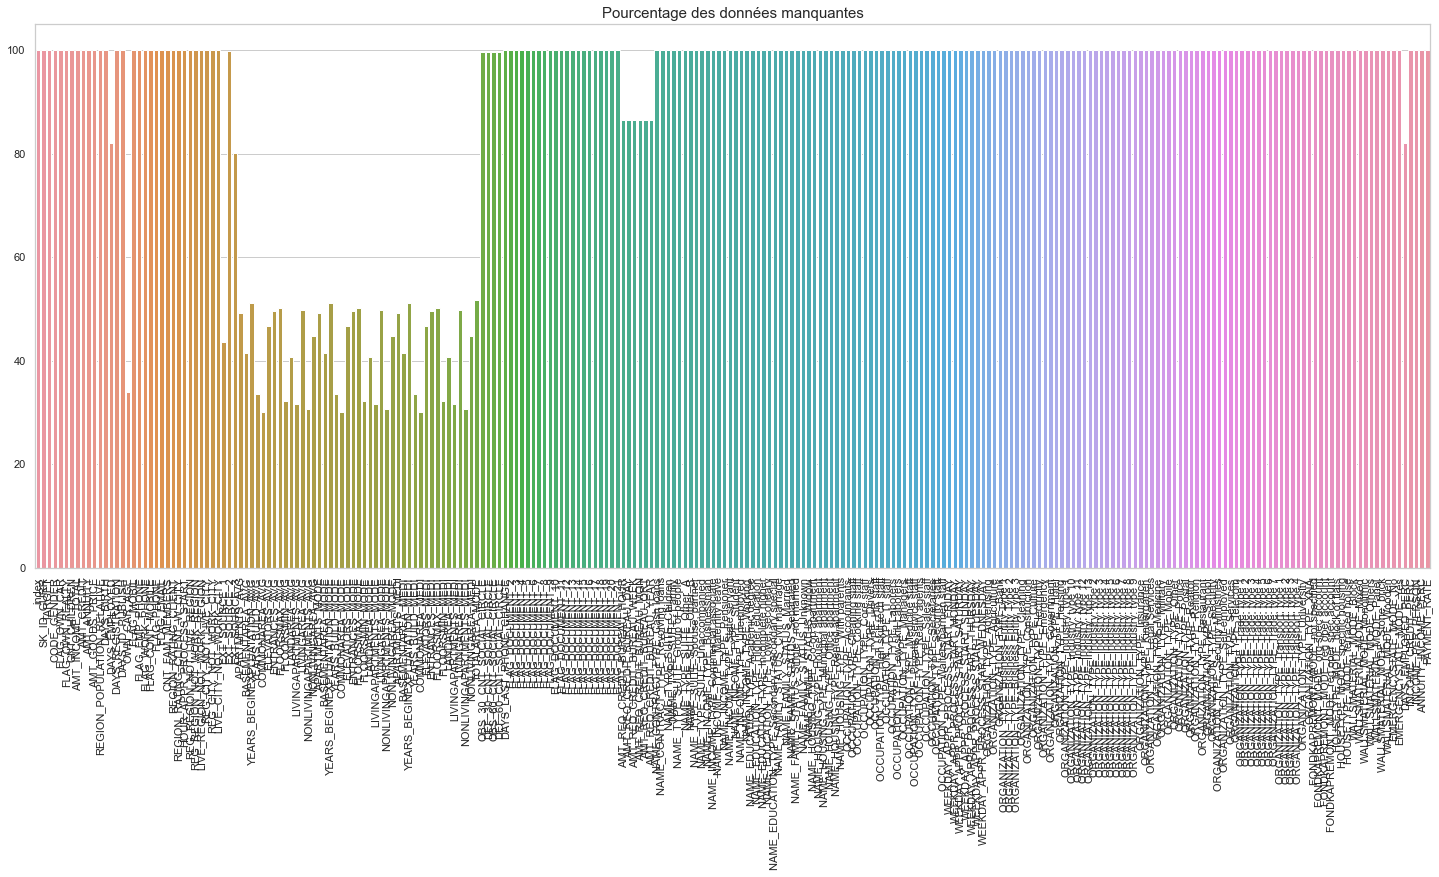

In [35]:
all_column, x_df, y_df = data_desc(train)

In [36]:
train_missing = pd.DataFrame(y_df, index = x_df, columns = ['Pour'])

In [37]:
train_missing

,Pour
index,100.000000
SK_ID_CURR,100.000000
TARGET,100.000000
CODE_GENDER,100.000000
FLAG_OWN_CAR,100.000000
...,...
DAYS_EMPLOYED_PERC,81.992605
INCOME_CREDIT_PERC,100.000000
INCOME_PER_PERSON,99.999350
ANNUITY_INCOME_PERC,99.996098


In [38]:
train_var_2_keep = list(train_missing[train_missing['Pour']>80].index)

In [39]:
#train_var_2_keep

In [40]:
train_1 = train[train_var_2_keep]

In [42]:
data_eda = train_1.copy()
data_eda

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,0,1,0,1,0,0.067329,0.498036,202500.0,0.121978,0.060749
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,0,0,0,1,0,0.070862,0.208736,135000.0,0.132217,0.027598
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,0,0,0,0,0,0.011814,0.500000,67500.0,0.100000,0.050000
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,0,0,0,0,0,0.159905,0.431748,67500.0,0.219900,0.094941
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,0,0,0,0,0,0.152418,0.236842,121500.0,0.179963,0.042623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,307506,456251,0.0,0,0,1,0,157500.0,254700.0,27558.0,...,0,1,0,1,0,0.025303,0.618375,157500.0,0.174971,0.108198
307507,307507,456252,0.0,1,0,0,0,72000.0,269550.0,12001.5,...,0,1,0,1,0,NaN,0.267112,72000.0,0.166687,0.044524
307508,307508,456253,0.0,1,0,0,0,153000.0,677664.0,29979.0,...,1,0,0,1,0,0.529266,0.225776,153000.0,0.195941,0.044239
307509,307509,456254,1.0,1,0,0,0,171000.0,370107.0,20205.0,...,0,1,0,1,0,0.400134,0.462029,85500.0,0.118158,0.054592


Data description :

Data head: 
    index  SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      0      100002     1.0            0             0                0   
1      1      100003     0.0            1             0                1   
2      2      100004     0.0            0             1                0   
3      3      100006     0.0            1             0                0   
4      4      100007     0.0            0             0                0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  ...  \
0             0          202500.0    406597.5      24700.5  ...   
1             0          270000.0   1293502.5      35698.5  ...   
2             0           67500.0    135000.0       6750.0  ...   
3             0          135000.0    312682.5      29686.5  ...   
4             0          121500.0    513000.0      21865.5  ...   

   WALLSMATERIAL_MODE_Panel  WALLSMATERIAL_MODE_Stone, brick  \
0                         0                

(['index',
  'SK_ID_CURR',
  'TARGET',
  'CODE_GENDER',
  'FLAG_OWN_CAR',
  'FLAG_OWN_REALTY',
  'CNT_CHILDREN',
  'AMT_INCOME_TOTAL',
  'AMT_CREDIT',
  'AMT_ANNUITY',
  'AMT_GOODS_PRICE',
  'REGION_POPULATION_RELATIVE',
  'DAYS_BIRTH',
  'DAYS_EMPLOYED',
  'DAYS_REGISTRATION',
  'DAYS_ID_PUBLISH',
  'FLAG_MOBIL',
  'FLAG_EMP_PHONE',
  'FLAG_WORK_PHONE',
  'FLAG_CONT_MOBILE',
  'FLAG_PHONE',
  'FLAG_EMAIL',
  'CNT_FAM_MEMBERS',
  'REGION_RATING_CLIENT',
  'REGION_RATING_CLIENT_W_CITY',
  'HOUR_APPR_PROCESS_START',
  'REG_REGION_NOT_LIVE_REGION',
  'REG_REGION_NOT_WORK_REGION',
  'LIVE_REGION_NOT_WORK_REGION',
  'REG_CITY_NOT_LIVE_CITY',
  'REG_CITY_NOT_WORK_CITY',
  'LIVE_CITY_NOT_WORK_CITY',
  'EXT_SOURCE_2',
  'EXT_SOURCE_3',
  'OBS_30_CNT_SOCIAL_CIRCLE',
  'DEF_30_CNT_SOCIAL_CIRCLE',
  'OBS_60_CNT_SOCIAL_CIRCLE',
  'DEF_60_CNT_SOCIAL_CIRCLE',
  'DAYS_LAST_PHONE_CHANGE',
  'FLAG_DOCUMENT_2',
  'FLAG_DOCUMENT_3',
  'FLAG_DOCUMENT_4',
  'FLAG_DOCUMENT_5',
  'FLAG_DOCUMENT_6',
  'FLAG_D

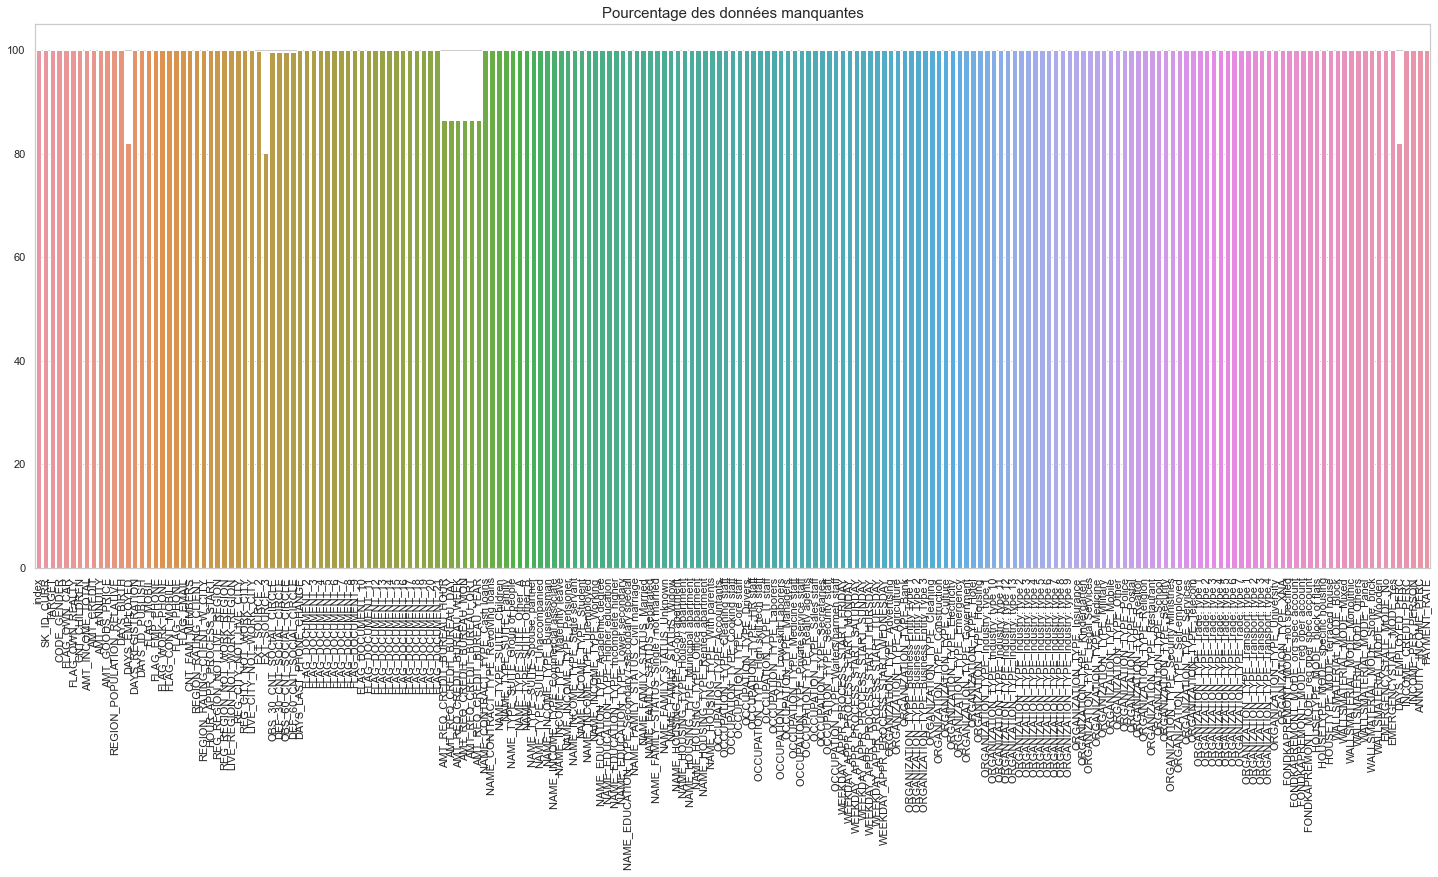

In [43]:
data_desc(train_1)

### Imputing : Median imputation of missing values

In [44]:
imputer_median = SimpleImputer(missing_values=np.nan, strategy='median')

In [45]:
# Fit on the training data
imputer_median.fit(train_1)
# imputer for handling missing values
#from sklearn.preprocessing import Imputer
#test = test.drop(columns = ['TARGET'])

# Need to impute missing values
train_1.iloc[:,:] = imputer_median.transform(train_1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [46]:
train_1

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,0.0,100002.0,1.0,0.0,0.0,0.0,0.0,202500.0,406597.5,24700.5,...,0.0,1.0,0.0,1.0,0.0,0.067329,0.498036,202500.0,0.121978,0.060749
1,1.0,100003.0,0.0,1.0,0.0,1.0,0.0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,1.0,0.0,0.070862,0.208736,135000.0,0.132217,0.027598
2,2.0,100004.0,0.0,0.0,1.0,0.0,0.0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.011814,0.500000,67500.0,0.100000,0.050000
3,3.0,100006.0,0.0,1.0,0.0,0.0,0.0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.0,0.159905,0.431748,67500.0,0.219900,0.094941
4,4.0,100007.0,0.0,0.0,0.0,0.0,0.0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.152418,0.236842,121500.0,0.179963,0.042623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,307506.0,456251.0,0.0,0.0,0.0,1.0,0.0,157500.0,254700.0,27558.0,...,0.0,1.0,0.0,1.0,0.0,0.025303,0.618375,157500.0,0.174971,0.108198
307507,307507.0,456252.0,0.0,1.0,0.0,0.0,0.0,72000.0,269550.0,12001.5,...,0.0,1.0,0.0,1.0,0.0,0.118733,0.267112,72000.0,0.166687,0.044524
307508,307508.0,456253.0,0.0,1.0,0.0,0.0,0.0,153000.0,677664.0,29979.0,...,1.0,0.0,0.0,1.0,0.0,0.529266,0.225776,153000.0,0.195941,0.044239
307509,307509.0,456254.0,1.0,1.0,0.0,0.0,0.0,171000.0,370107.0,20205.0,...,0.0,1.0,0.0,1.0,0.0,0.400134,0.462029,85500.0,0.118158,0.054592


Data description :

Data head: 
    index  SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0    0.0    100002.0     1.0          0.0           0.0              0.0   
1    1.0    100003.0     0.0          1.0           0.0              1.0   
2    2.0    100004.0     0.0          0.0           1.0              0.0   
3    3.0    100006.0     0.0          1.0           0.0              0.0   
4    4.0    100007.0     0.0          0.0           0.0              0.0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  ...  \
0           0.0          202500.0    406597.5      24700.5  ...   
1           0.0          270000.0   1293502.5      35698.5  ...   
2           0.0           67500.0    135000.0       6750.0  ...   
3           0.0          135000.0    312682.5      29686.5  ...   
4           0.0          121500.0    513000.0      21865.5  ...   

   WALLSMATERIAL_MODE_Panel  WALLSMATERIAL_MODE_Stone, brick  \
0                       0.0                

(['index',
  'SK_ID_CURR',
  'TARGET',
  'CODE_GENDER',
  'FLAG_OWN_CAR',
  'FLAG_OWN_REALTY',
  'CNT_CHILDREN',
  'AMT_INCOME_TOTAL',
  'AMT_CREDIT',
  'AMT_ANNUITY',
  'AMT_GOODS_PRICE',
  'REGION_POPULATION_RELATIVE',
  'DAYS_BIRTH',
  'DAYS_EMPLOYED',
  'DAYS_REGISTRATION',
  'DAYS_ID_PUBLISH',
  'FLAG_MOBIL',
  'FLAG_EMP_PHONE',
  'FLAG_WORK_PHONE',
  'FLAG_CONT_MOBILE',
  'FLAG_PHONE',
  'FLAG_EMAIL',
  'CNT_FAM_MEMBERS',
  'REGION_RATING_CLIENT',
  'REGION_RATING_CLIENT_W_CITY',
  'HOUR_APPR_PROCESS_START',
  'REG_REGION_NOT_LIVE_REGION',
  'REG_REGION_NOT_WORK_REGION',
  'LIVE_REGION_NOT_WORK_REGION',
  'REG_CITY_NOT_LIVE_CITY',
  'REG_CITY_NOT_WORK_CITY',
  'LIVE_CITY_NOT_WORK_CITY',
  'EXT_SOURCE_2',
  'EXT_SOURCE_3',
  'OBS_30_CNT_SOCIAL_CIRCLE',
  'DEF_30_CNT_SOCIAL_CIRCLE',
  'OBS_60_CNT_SOCIAL_CIRCLE',
  'DEF_60_CNT_SOCIAL_CIRCLE',
  'DAYS_LAST_PHONE_CHANGE',
  'FLAG_DOCUMENT_2',
  'FLAG_DOCUMENT_3',
  'FLAG_DOCUMENT_4',
  'FLAG_DOCUMENT_5',
  'FLAG_DOCUMENT_6',
  'FLAG_D

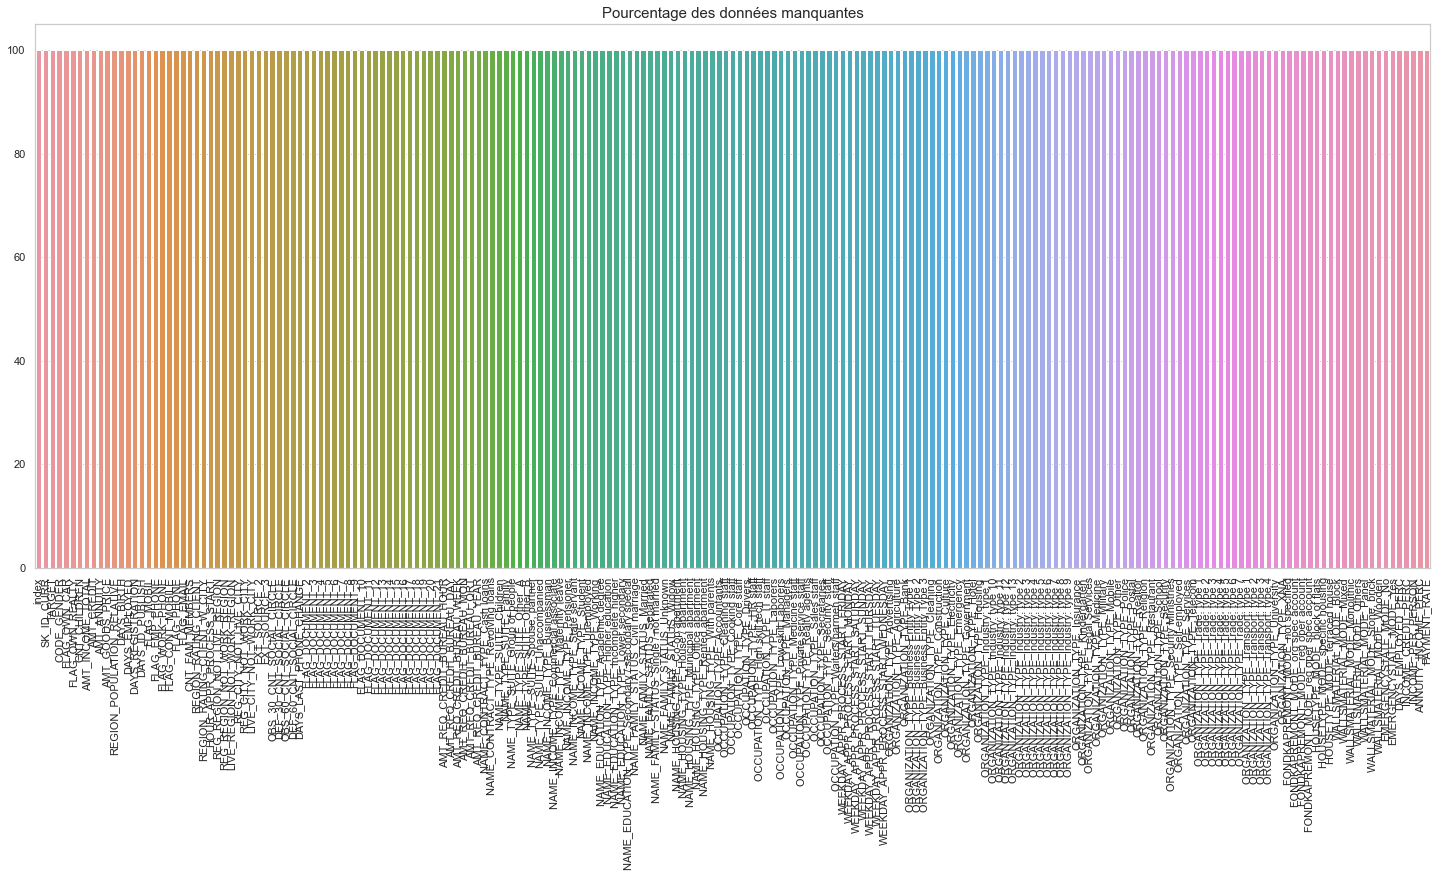

In [47]:
data_desc(train_1)

### Selection des variables les plus importantes

***Préparation la base de données pour la prédiction des données de l'énergie totale***

In [48]:
y=train_1['TARGET']
X=train_1.drop(columns=['TARGET','index','SK_ID_CURR'])

In [49]:
minmax_scale = MinMaxScaler()

In [50]:
X_minmax = minmax_scale.fit_transform(X)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X_minmax, y, test_size=0.30, random_state=42)

In [52]:
print("Entrainement: {} lignes,\nTest: {} lignes.\n".format(X_train.shape[0],X_test.shape[0]))

Entrainement: 215254 lignes,
Test: 92253 lignes.



In [53]:
rf_classifier = RandomForestClassifier(n_estimators = 500, random_state = 50, verbose = 1, n_jobs = -1)

rf_classifier.fit(X_train, y_train)

### Afficher les performances sur Train
#print_score(rf_regressor, X_train_elec, y_train_elec, X_test_elec, y_test_elec, train=True)
### Afficher les performances sur Test
#print_score(rf_regressor, X_train_elec, y_train_elec, X_test_elec, y_test_elec, train=False)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  6.7min finished


RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=50, verbose=1)

In [54]:
feature_importance = rf_classifier.feature_importances_

In [55]:
features = X.columns

In [56]:
feature_importance_df = pd.DataFrame({'Feature':features,'Importance':feature_importance})

In [57]:
feature_importance_df

,Feature,Importance
0,CODE_GENDER,0.005764
1,FLAG_OWN_CAR,0.005507
2,FLAG_OWN_REALTY,0.005941
3,CNT_CHILDREN,0.007948
4,AMT_INCOME_TOTAL,0.026067
...,...,...
195,DAYS_EMPLOYED_PERC,0.032293
196,INCOME_CREDIT_PERC,0.033721
197,INCOME_PER_PERSON,0.028478
198,ANNUITY_INCOME_PERC,0.034695


In [58]:
feature_importance_df = feature_importance_df.sort_values(by=['Importance'], ascending=False)
feature_importance_df.head(40)

,Feature,Importance
29,EXT_SOURCE_2,0.055574
30,EXT_SOURCE_3,0.051683
9,DAYS_BIRTH,0.037696
12,DAYS_ID_PUBLISH,0.037464
11,DAYS_REGISTRATION,0.036737
199,PAYMENT_RATE,0.035509
198,ANNUITY_INCOME_PERC,0.034695
196,INCOME_CREDIT_PERC,0.033721
6,AMT_ANNUITY,0.033164
35,DAYS_LAST_PHONE_CHANGE,0.033122


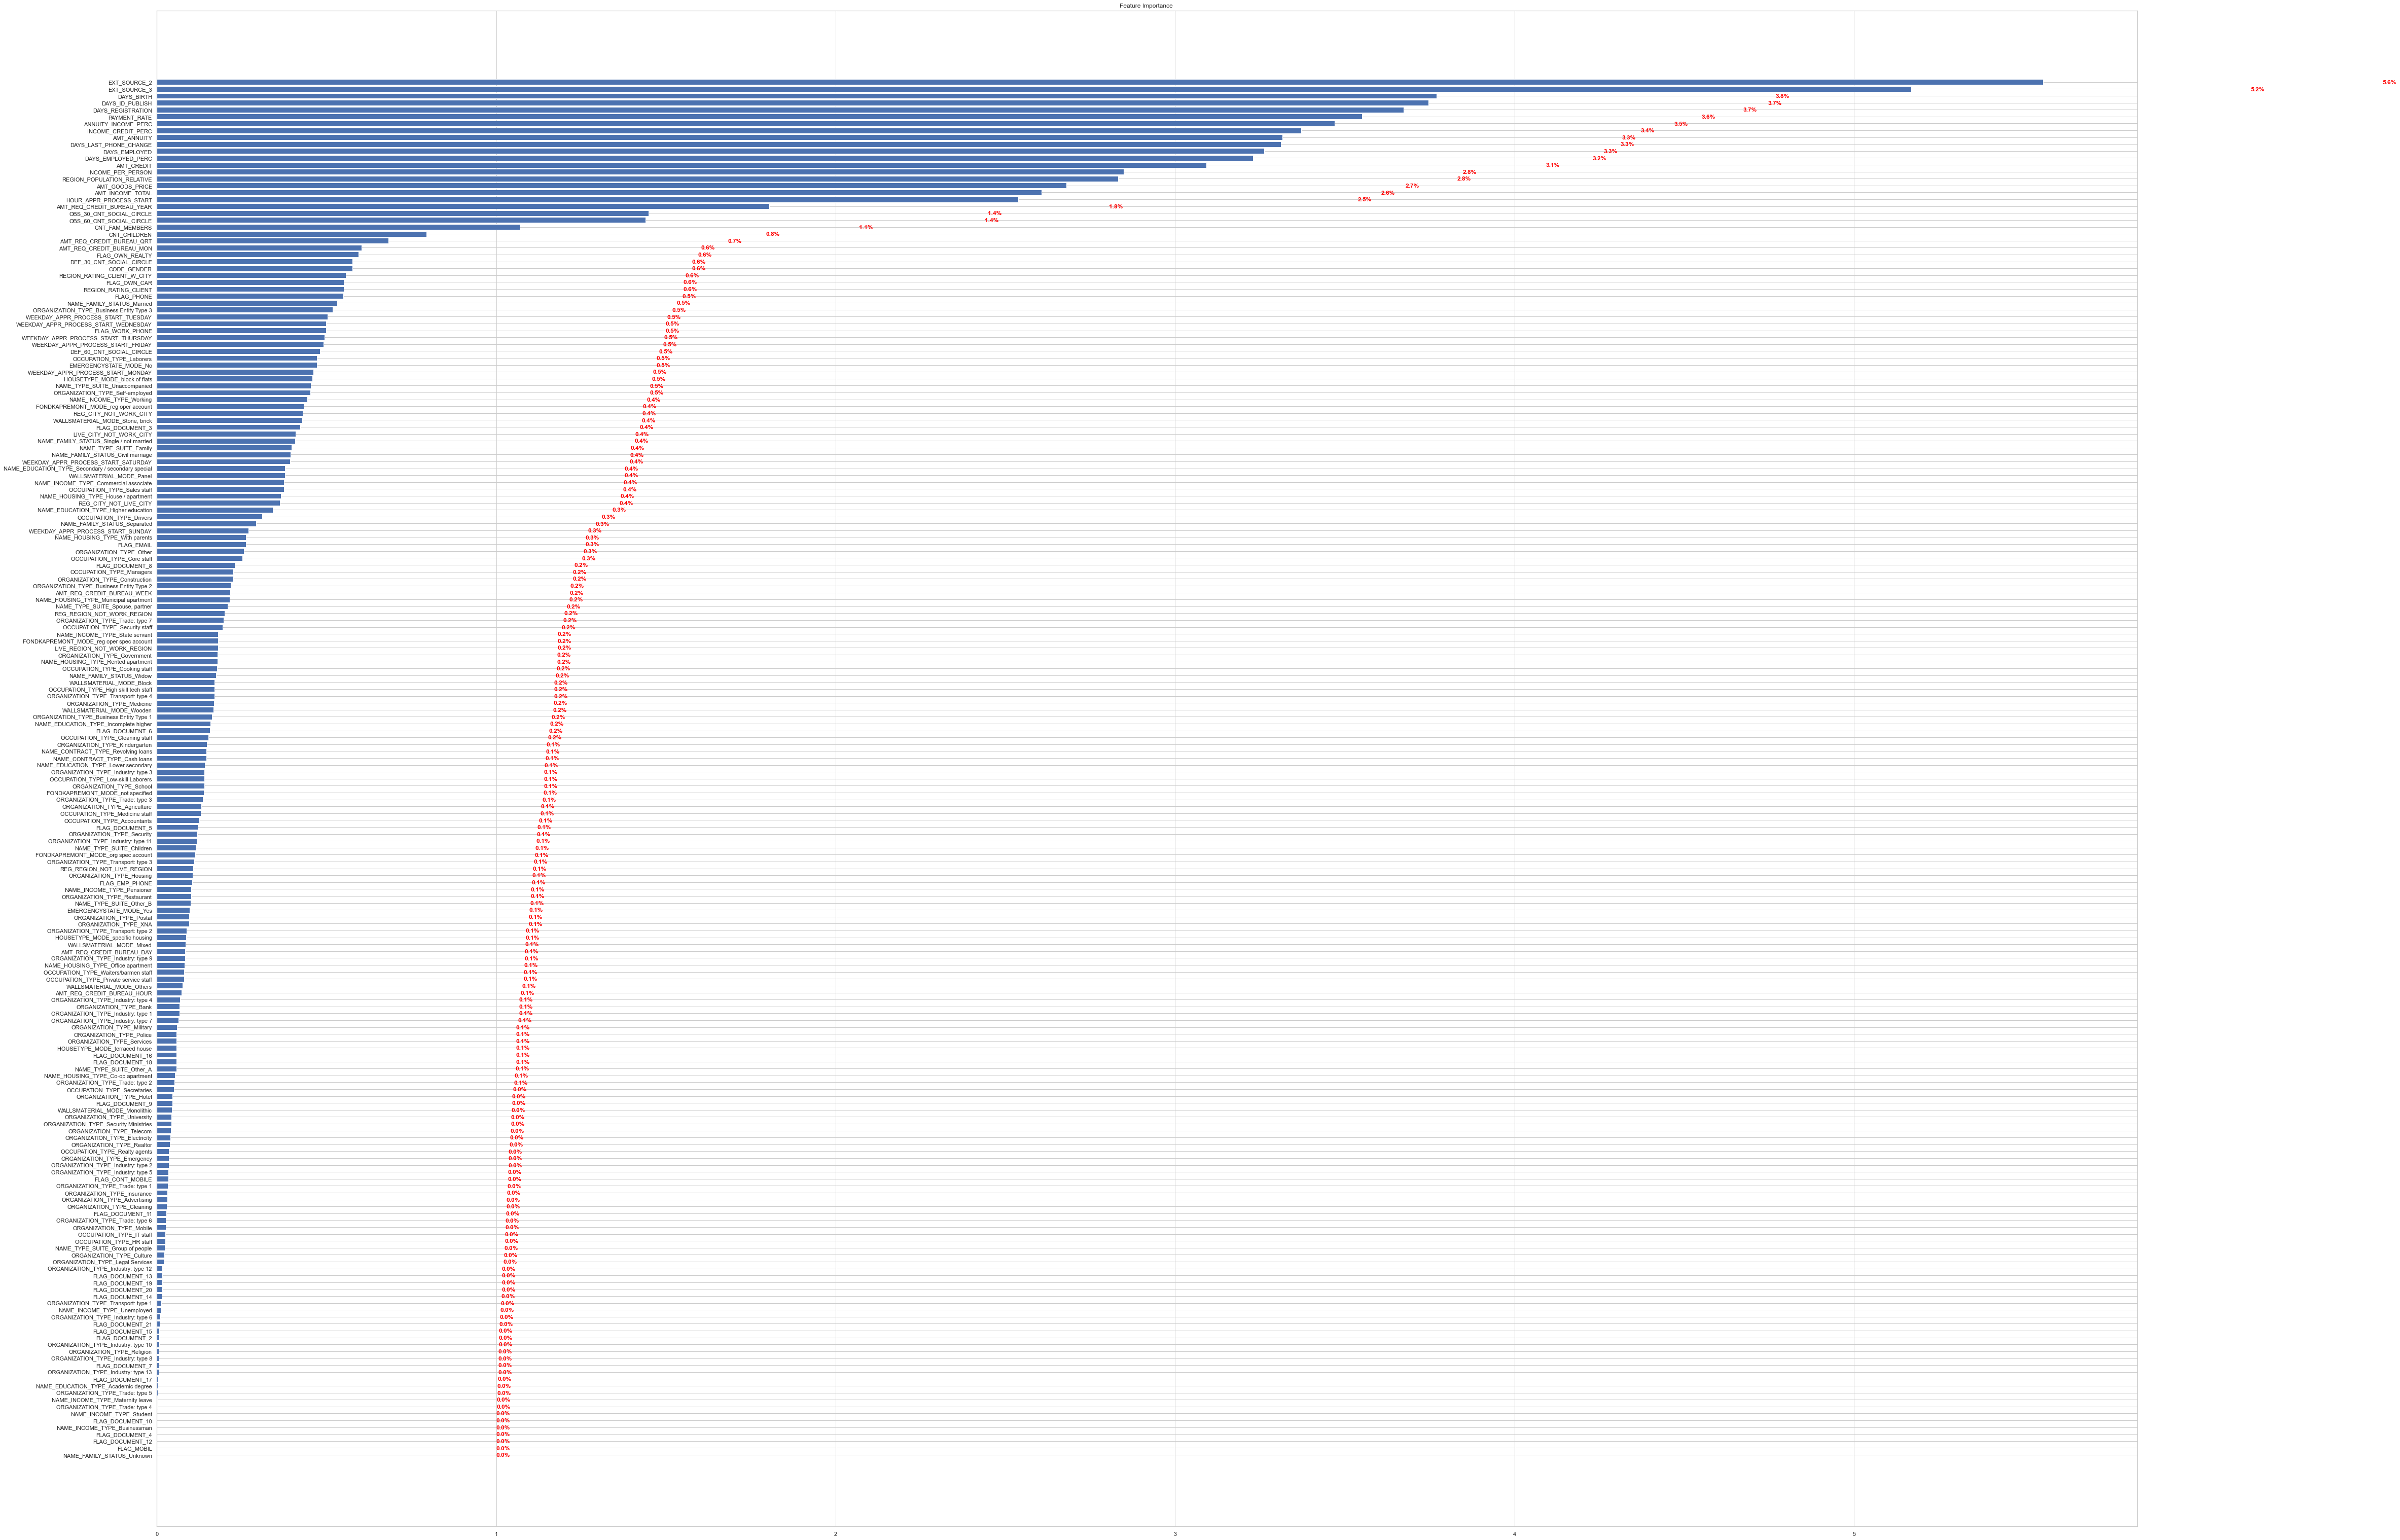

In [59]:
feature_importance = rf_classifier.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(70, 55))
plt.barh(pos, feature_importance[sorted_idx]*100, align='center')
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.title('Feature Importance ')
for i, v in enumerate(feature_importance[sorted_idx]*100):
    plt.text(v + 1, i + .25, str(round(v,1))+ "%", color='red', fontweight='bold')

In [60]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(50,34))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

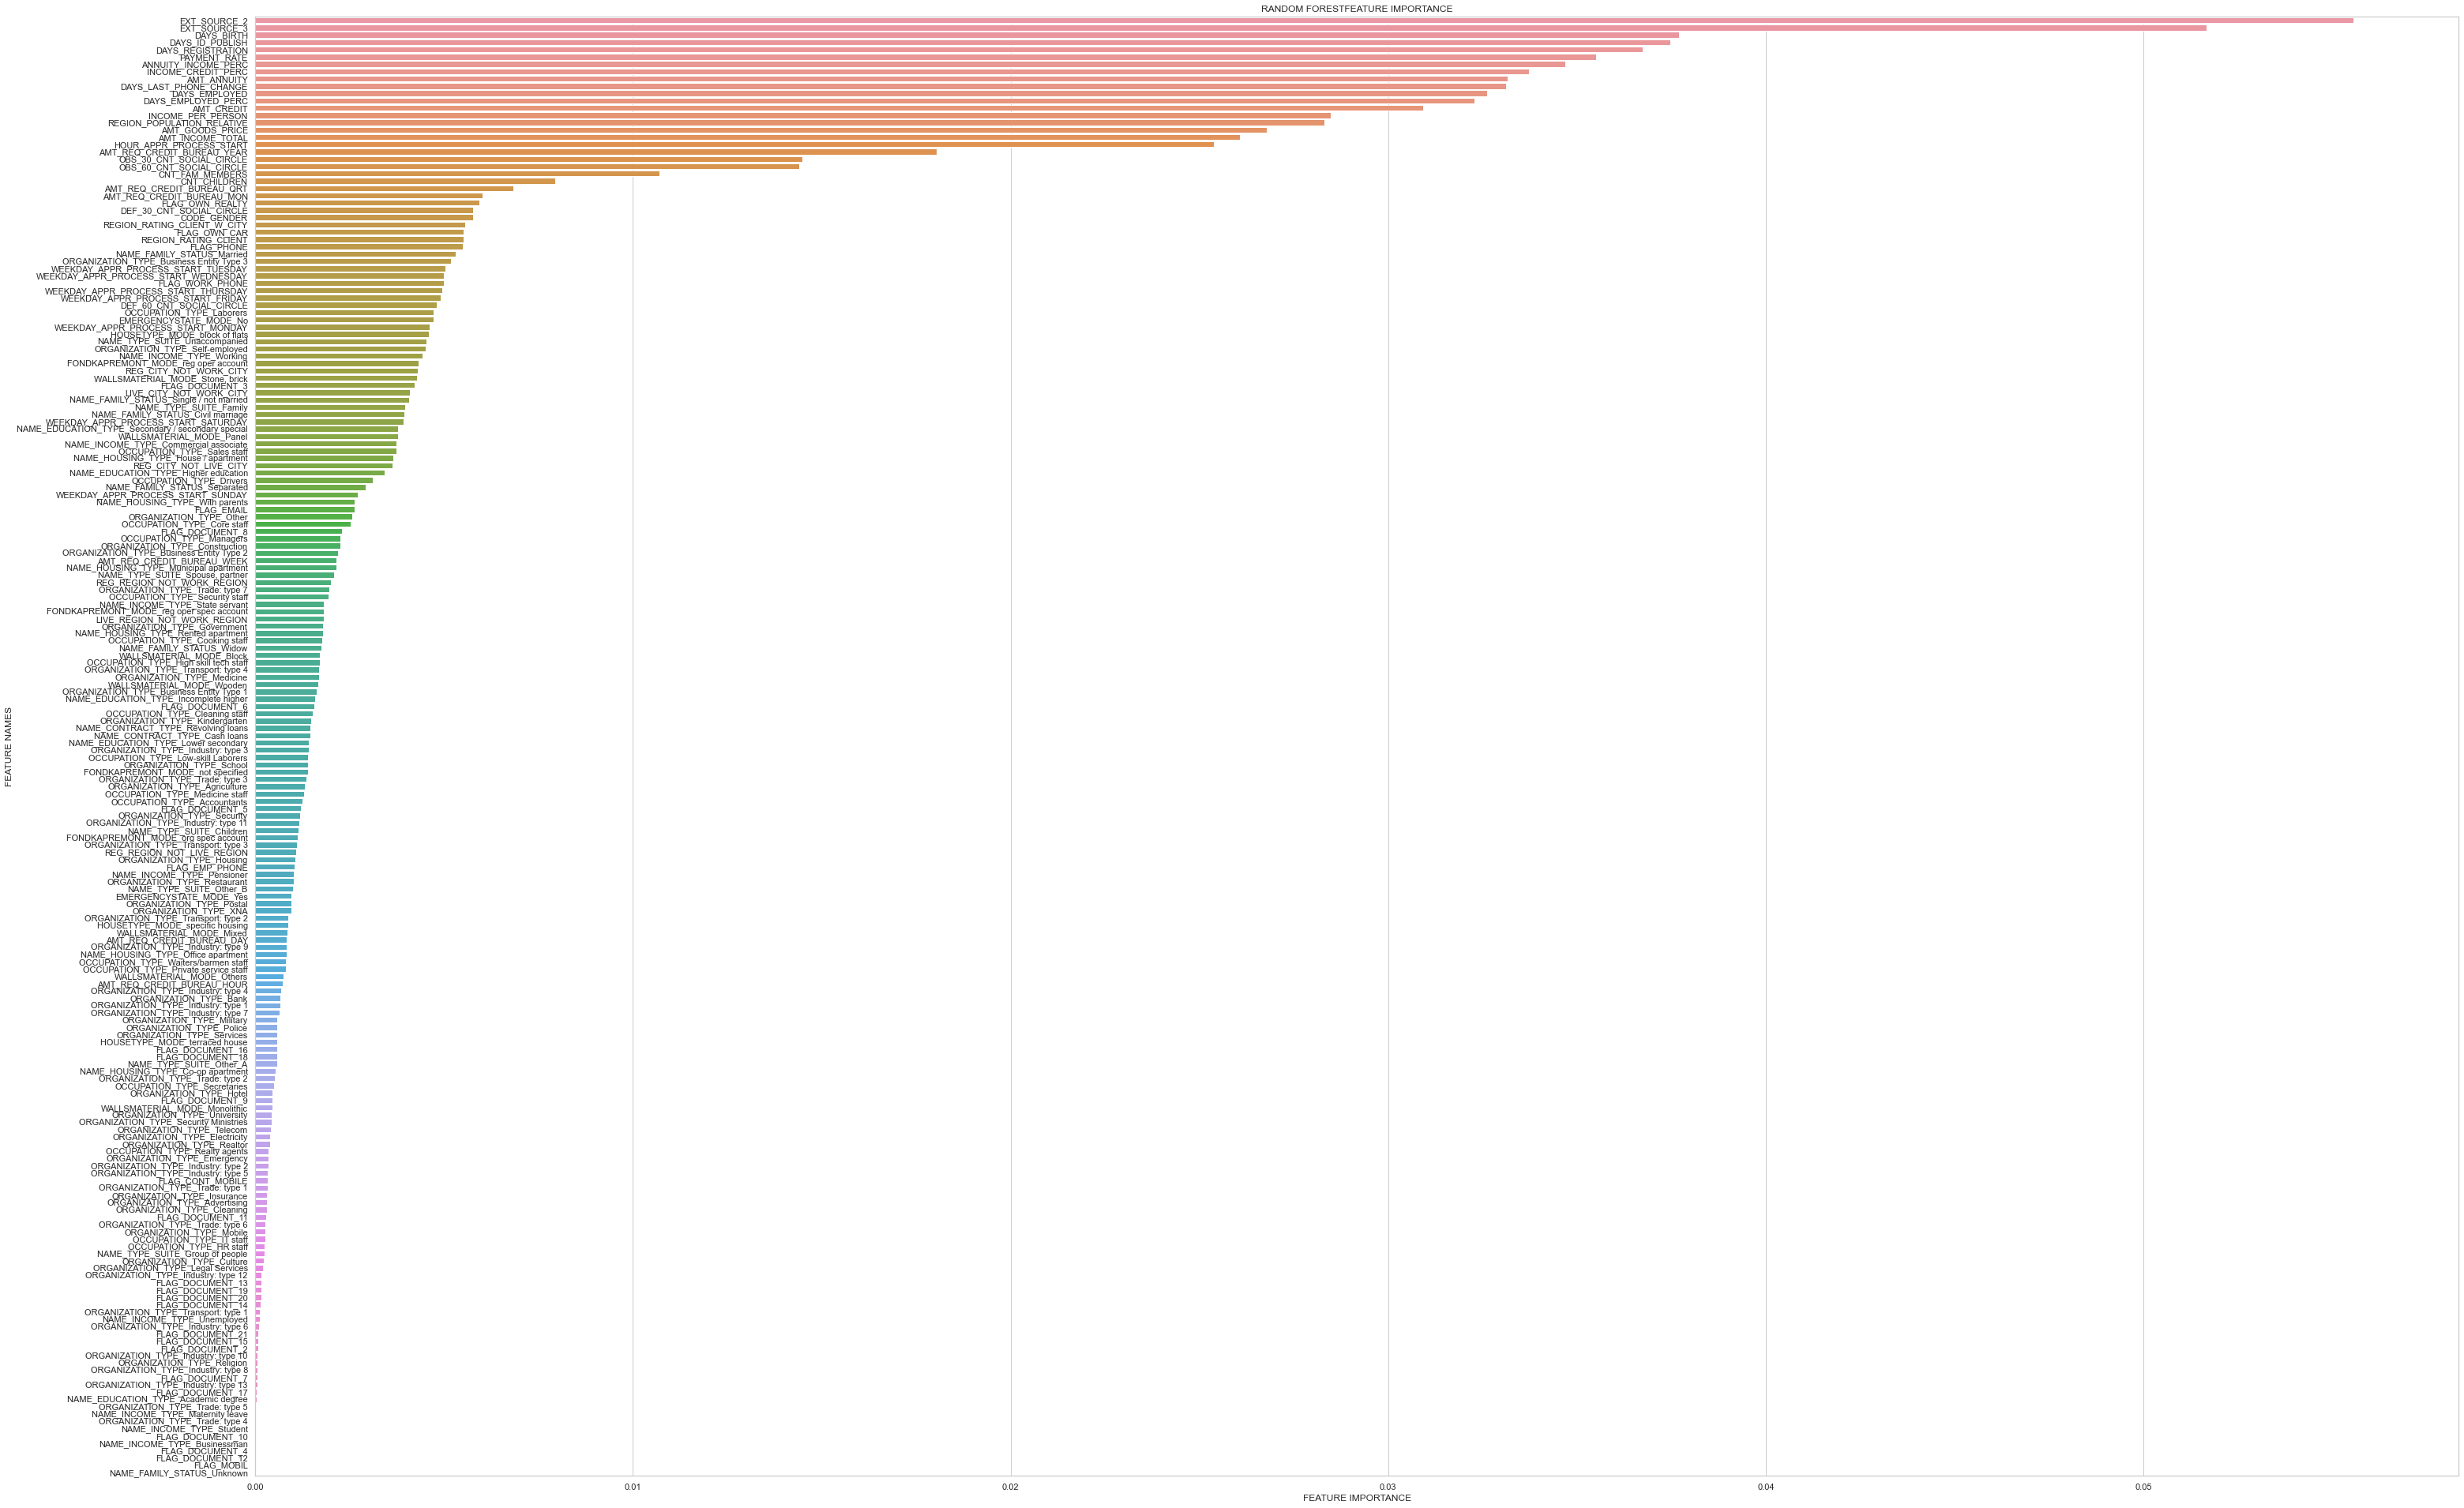

In [61]:
plot_feature_importance(rf_classifier.feature_importances_,X.columns,'RANDOM FOREST')

***Final Dataset***

In [62]:
feature_importance_df.set_index('Feature',inplace = True)

In [63]:
train_list =feature_importance_df.iloc[:19]
#prende selon la rang

In [64]:
train_list

,Importance
Feature,
EXT_SOURCE_2,0.055574
EXT_SOURCE_3,0.051683
DAYS_BIRTH,0.037696
DAYS_ID_PUBLISH,0.037464
DAYS_REGISTRATION,0.036737
PAYMENT_RATE,0.035509
ANNUITY_INCOME_PERC,0.034695
INCOME_CREDIT_PERC,0.033721
AMT_ANNUITY,0.033164


In [65]:
train_list_index = ['index','SK_ID_CURR','TARGET'] + train_list.index.tolist()

In [66]:
train_list_index

['index',
 'SK_ID_CURR',
 'TARGET',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'DAYS_ID_PUBLISH',
 'DAYS_REGISTRATION',
 'PAYMENT_RATE',
 'ANNUITY_INCOME_PERC',
 'INCOME_CREDIT_PERC',
 'AMT_ANNUITY',
 'DAYS_LAST_PHONE_CHANGE',
 'DAYS_EMPLOYED',
 'DAYS_EMPLOYED_PERC',
 'AMT_CREDIT',
 'INCOME_PER_PERSON',
 'REGION_POPULATION_RELATIVE',
 'AMT_GOODS_PRICE',
 'AMT_INCOME_TOTAL',
 'HOUR_APPR_PROCESS_START',
 'AMT_REQ_CREDIT_BUREAU_YEAR']

In [67]:
train_2 = train_1[train_list_index]
train_2

,index,SK_ID_CURR,TARGET,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,DAYS_ID_PUBLISH,DAYS_REGISTRATION,PAYMENT_RATE,ANNUITY_INCOME_PERC,...,DAYS_LAST_PHONE_CHANGE,DAYS_EMPLOYED,DAYS_EMPLOYED_PERC,AMT_CREDIT,INCOME_PER_PERSON,REGION_POPULATION_RELATIVE,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,HOUR_APPR_PROCESS_START,AMT_REQ_CREDIT_BUREAU_YEAR
0,0.0,100002.0,1.0,0.262949,0.139376,-9461.0,-2120.0,-3648.0,0.060749,0.121978,...,-1134.0,-637.0,0.067329,406597.5,202500.0,0.018801,351000.0,202500.0,10.0,1.0
1,1.0,100003.0,0.0,0.622246,0.535276,-16765.0,-291.0,-1186.0,0.027598,0.132217,...,-828.0,-1188.0,0.070862,1293502.5,135000.0,0.003541,1129500.0,270000.0,11.0,0.0
2,2.0,100004.0,0.0,0.555912,0.729567,-19046.0,-2531.0,-4260.0,0.050000,0.100000,...,-815.0,-225.0,0.011814,135000.0,67500.0,0.010032,135000.0,67500.0,9.0,0.0
3,3.0,100006.0,0.0,0.650442,0.535276,-19005.0,-2437.0,-9833.0,0.094941,0.219900,...,-617.0,-3039.0,0.159905,312682.5,67500.0,0.008019,297000.0,135000.0,17.0,1.0
4,4.0,100007.0,0.0,0.322738,0.535276,-19932.0,-3458.0,-4311.0,0.042623,0.179963,...,-1106.0,-3038.0,0.152418,513000.0,121500.0,0.028663,513000.0,121500.0,11.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,307506.0,456251.0,0.0,0.681632,0.535276,-9327.0,-1982.0,-8456.0,0.108198,0.174971,...,-273.0,-236.0,0.025303,254700.0,157500.0,0.032561,225000.0,157500.0,15.0,1.0
307507,307507.0,456252.0,0.0,0.115992,0.535276,-20775.0,-4090.0,-4388.0,0.044524,0.166687,...,0.0,-1648.0,0.118733,269550.0,72000.0,0.025164,225000.0,72000.0,8.0,1.0
307508,307508.0,456253.0,0.0,0.535722,0.218859,-14966.0,-5150.0,-6737.0,0.044239,0.195941,...,-1909.0,-7921.0,0.529266,677664.0,153000.0,0.005002,585000.0,153000.0,9.0,1.0
307509,307509.0,456254.0,1.0,0.514163,0.661024,-11961.0,-931.0,-2562.0,0.054592,0.118158,...,-322.0,-4786.0,0.400134,370107.0,85500.0,0.005313,319500.0,171000.0,9.0,0.0


### EDA

In [68]:
train_list_index

['index',
 'SK_ID_CURR',
 'TARGET',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'DAYS_ID_PUBLISH',
 'DAYS_REGISTRATION',
 'PAYMENT_RATE',
 'ANNUITY_INCOME_PERC',
 'INCOME_CREDIT_PERC',
 'AMT_ANNUITY',
 'DAYS_LAST_PHONE_CHANGE',
 'DAYS_EMPLOYED',
 'DAYS_EMPLOYED_PERC',
 'AMT_CREDIT',
 'INCOME_PER_PERSON',
 'REGION_POPULATION_RELATIVE',
 'AMT_GOODS_PRICE',
 'AMT_INCOME_TOTAL',
 'HOUR_APPR_PROCESS_START',
 'AMT_REQ_CREDIT_BUREAU_YEAR']

***Analyse univarie***

In [69]:
def plot_b_distribution(feature,color):
    plt.figure(figsize=(10,6))
    plt.title("Distribution of %s" % feature)
    sns.distplot(train_2[feature],color=color, kde=True,bins=100)
    plt.show()

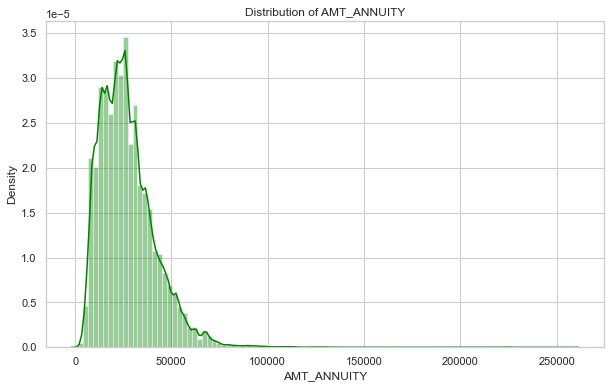

In [70]:
plot_b_distribution('AMT_ANNUITY','green')

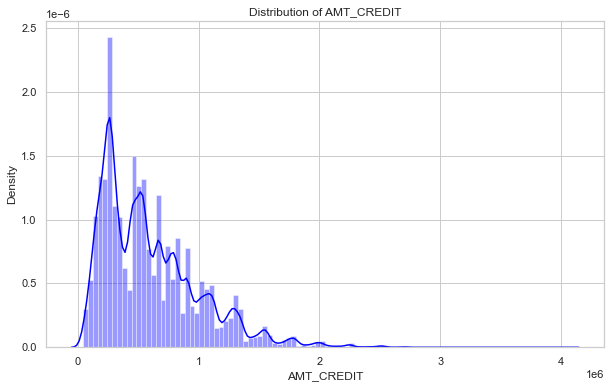

In [71]:
plot_b_distribution('AMT_CREDIT','blue')

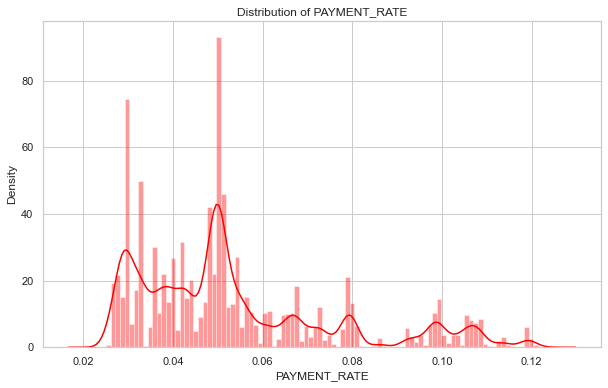

In [72]:
plot_b_distribution('PAYMENT_RATE','red')

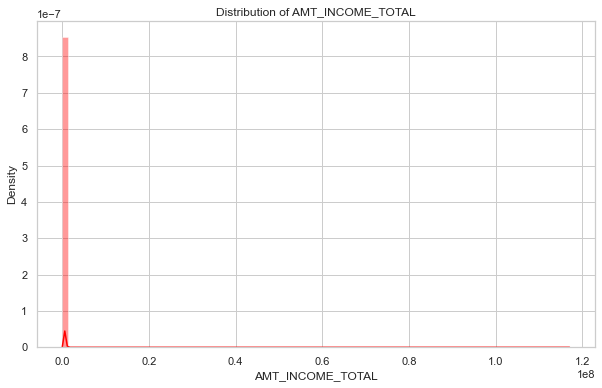

In [73]:
plot_b_distribution('AMT_INCOME_TOTAL','red')

Text(0, 0.5, 'Count')

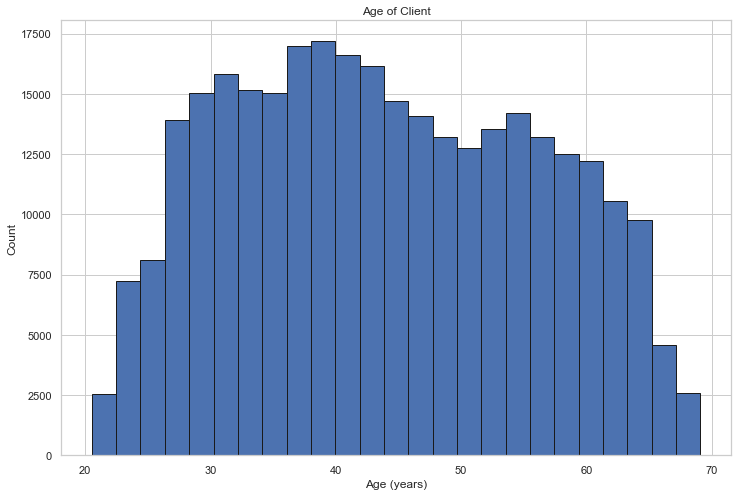

In [74]:
plt.hist(-(train_2['DAYS_BIRTH'] / 365), edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count')

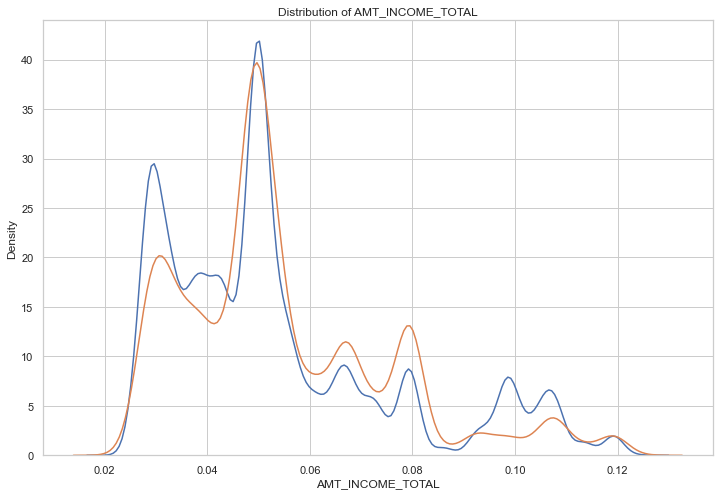

In [75]:
sb.kdeplot(train_2.loc[train_2['TARGET'] == 0, 'PAYMENT_RATE'], label = 'target == 0')
sns.kdeplot(train_2.loc[train_2['TARGET'] == 1, 'PAYMENT_RATE'], label = 'target == 1')
plt.xlabel('AMT_INCOME_TOTAL'); plt.ylabel('Density'); plt.title('Distribution of AMT_INCOME_TOTAL');

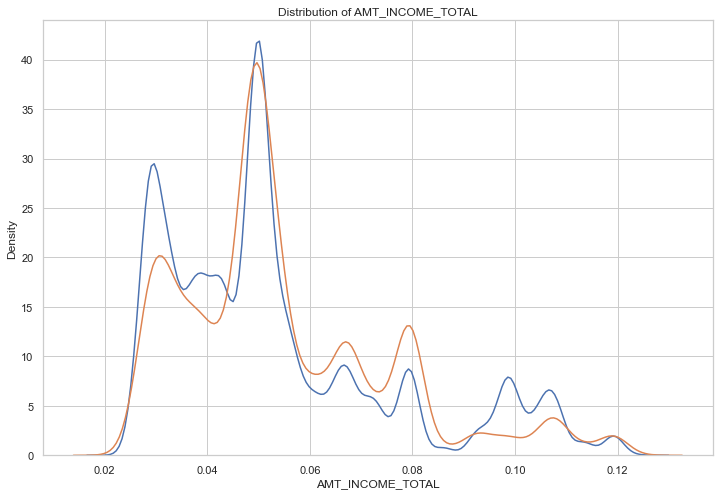

In [76]:
sb.kdeplot(train_2.loc[train_2['TARGET'] == 0, 'PAYMENT_RATE'], label = 'target == 0')
sns.kdeplot(train_2.loc[train_2['TARGET'] == 1, 'PAYMENT_RATE'], label = 'target == 1')
plt.xlabel('AMT_INCOME_TOTAL'); plt.ylabel('Density'); plt.title('Distribution of AMT_INCOME_TOTAL');

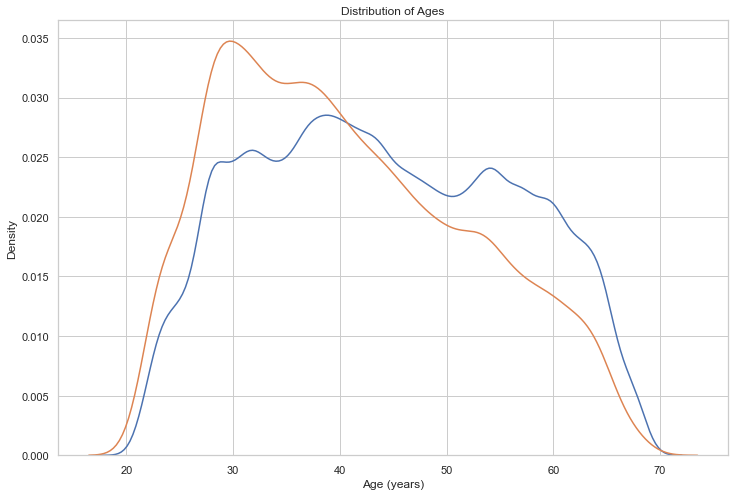

In [77]:
sb.kdeplot(train_2.loc[train_2['TARGET'] == 0, 'DAYS_BIRTH'] / -365, label = 'target == 0')
sns.kdeplot(train_2.loc[train_2['TARGET'] == 1, 'DAYS_BIRTH'] / -365, label = 'target == 1')
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

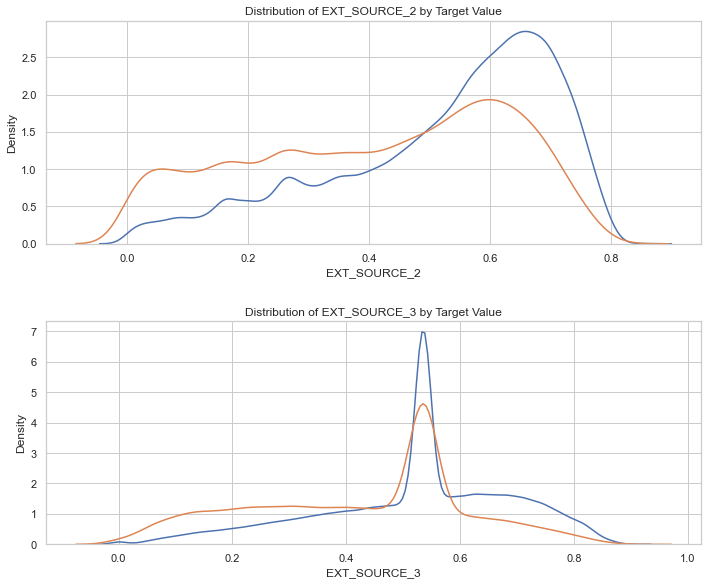

In [78]:
plt.figure(figsize = (10, 12))
for i, source in enumerate(['EXT_SOURCE_2', 'EXT_SOURCE_3']):
        # сабплот
    plt.subplot(3, 1, i + 1)
        # отрисовка качественных займов
    sb.kdeplot(train_2.loc[train_2['TARGET'] == 0, source], label = 'target == 0')
        # отрисовка дефолтных займов
    sb.kdeplot(train_2.loc[train_2['TARGET'] == 1, source], label = 'target == 1')
        # метки
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
plt.tight_layout(h_pad = 2.5)

In [79]:
data_eda = train_1[train_list_index]
data_eda

,index,SK_ID_CURR,TARGET,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,DAYS_ID_PUBLISH,DAYS_REGISTRATION,PAYMENT_RATE,ANNUITY_INCOME_PERC,...,DAYS_LAST_PHONE_CHANGE,DAYS_EMPLOYED,DAYS_EMPLOYED_PERC,AMT_CREDIT,INCOME_PER_PERSON,REGION_POPULATION_RELATIVE,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,HOUR_APPR_PROCESS_START,AMT_REQ_CREDIT_BUREAU_YEAR
0,0.0,100002.0,1.0,0.262949,0.139376,-9461.0,-2120.0,-3648.0,0.060749,0.121978,...,-1134.0,-637.0,0.067329,406597.5,202500.0,0.018801,351000.0,202500.0,10.0,1.0
1,1.0,100003.0,0.0,0.622246,0.535276,-16765.0,-291.0,-1186.0,0.027598,0.132217,...,-828.0,-1188.0,0.070862,1293502.5,135000.0,0.003541,1129500.0,270000.0,11.0,0.0
2,2.0,100004.0,0.0,0.555912,0.729567,-19046.0,-2531.0,-4260.0,0.050000,0.100000,...,-815.0,-225.0,0.011814,135000.0,67500.0,0.010032,135000.0,67500.0,9.0,0.0
3,3.0,100006.0,0.0,0.650442,0.535276,-19005.0,-2437.0,-9833.0,0.094941,0.219900,...,-617.0,-3039.0,0.159905,312682.5,67500.0,0.008019,297000.0,135000.0,17.0,1.0
4,4.0,100007.0,0.0,0.322738,0.535276,-19932.0,-3458.0,-4311.0,0.042623,0.179963,...,-1106.0,-3038.0,0.152418,513000.0,121500.0,0.028663,513000.0,121500.0,11.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,307506.0,456251.0,0.0,0.681632,0.535276,-9327.0,-1982.0,-8456.0,0.108198,0.174971,...,-273.0,-236.0,0.025303,254700.0,157500.0,0.032561,225000.0,157500.0,15.0,1.0
307507,307507.0,456252.0,0.0,0.115992,0.535276,-20775.0,-4090.0,-4388.0,0.044524,0.166687,...,0.0,-1648.0,0.118733,269550.0,72000.0,0.025164,225000.0,72000.0,8.0,1.0
307508,307508.0,456253.0,0.0,0.535722,0.218859,-14966.0,-5150.0,-6737.0,0.044239,0.195941,...,-1909.0,-7921.0,0.529266,677664.0,153000.0,0.005002,585000.0,153000.0,9.0,1.0
307509,307509.0,456254.0,1.0,0.514163,0.661024,-11961.0,-931.0,-2562.0,0.054592,0.118158,...,-322.0,-4786.0,0.400134,370107.0,85500.0,0.005313,319500.0,171000.0,9.0,0.0


***Analyse bivariée***

***Analyse multivariée***

***Heatmap***

In [80]:
# ajouter une heatmap qui montre la différence

Text(0.5, 1.0, 'Heatmap de corrélation des variables')

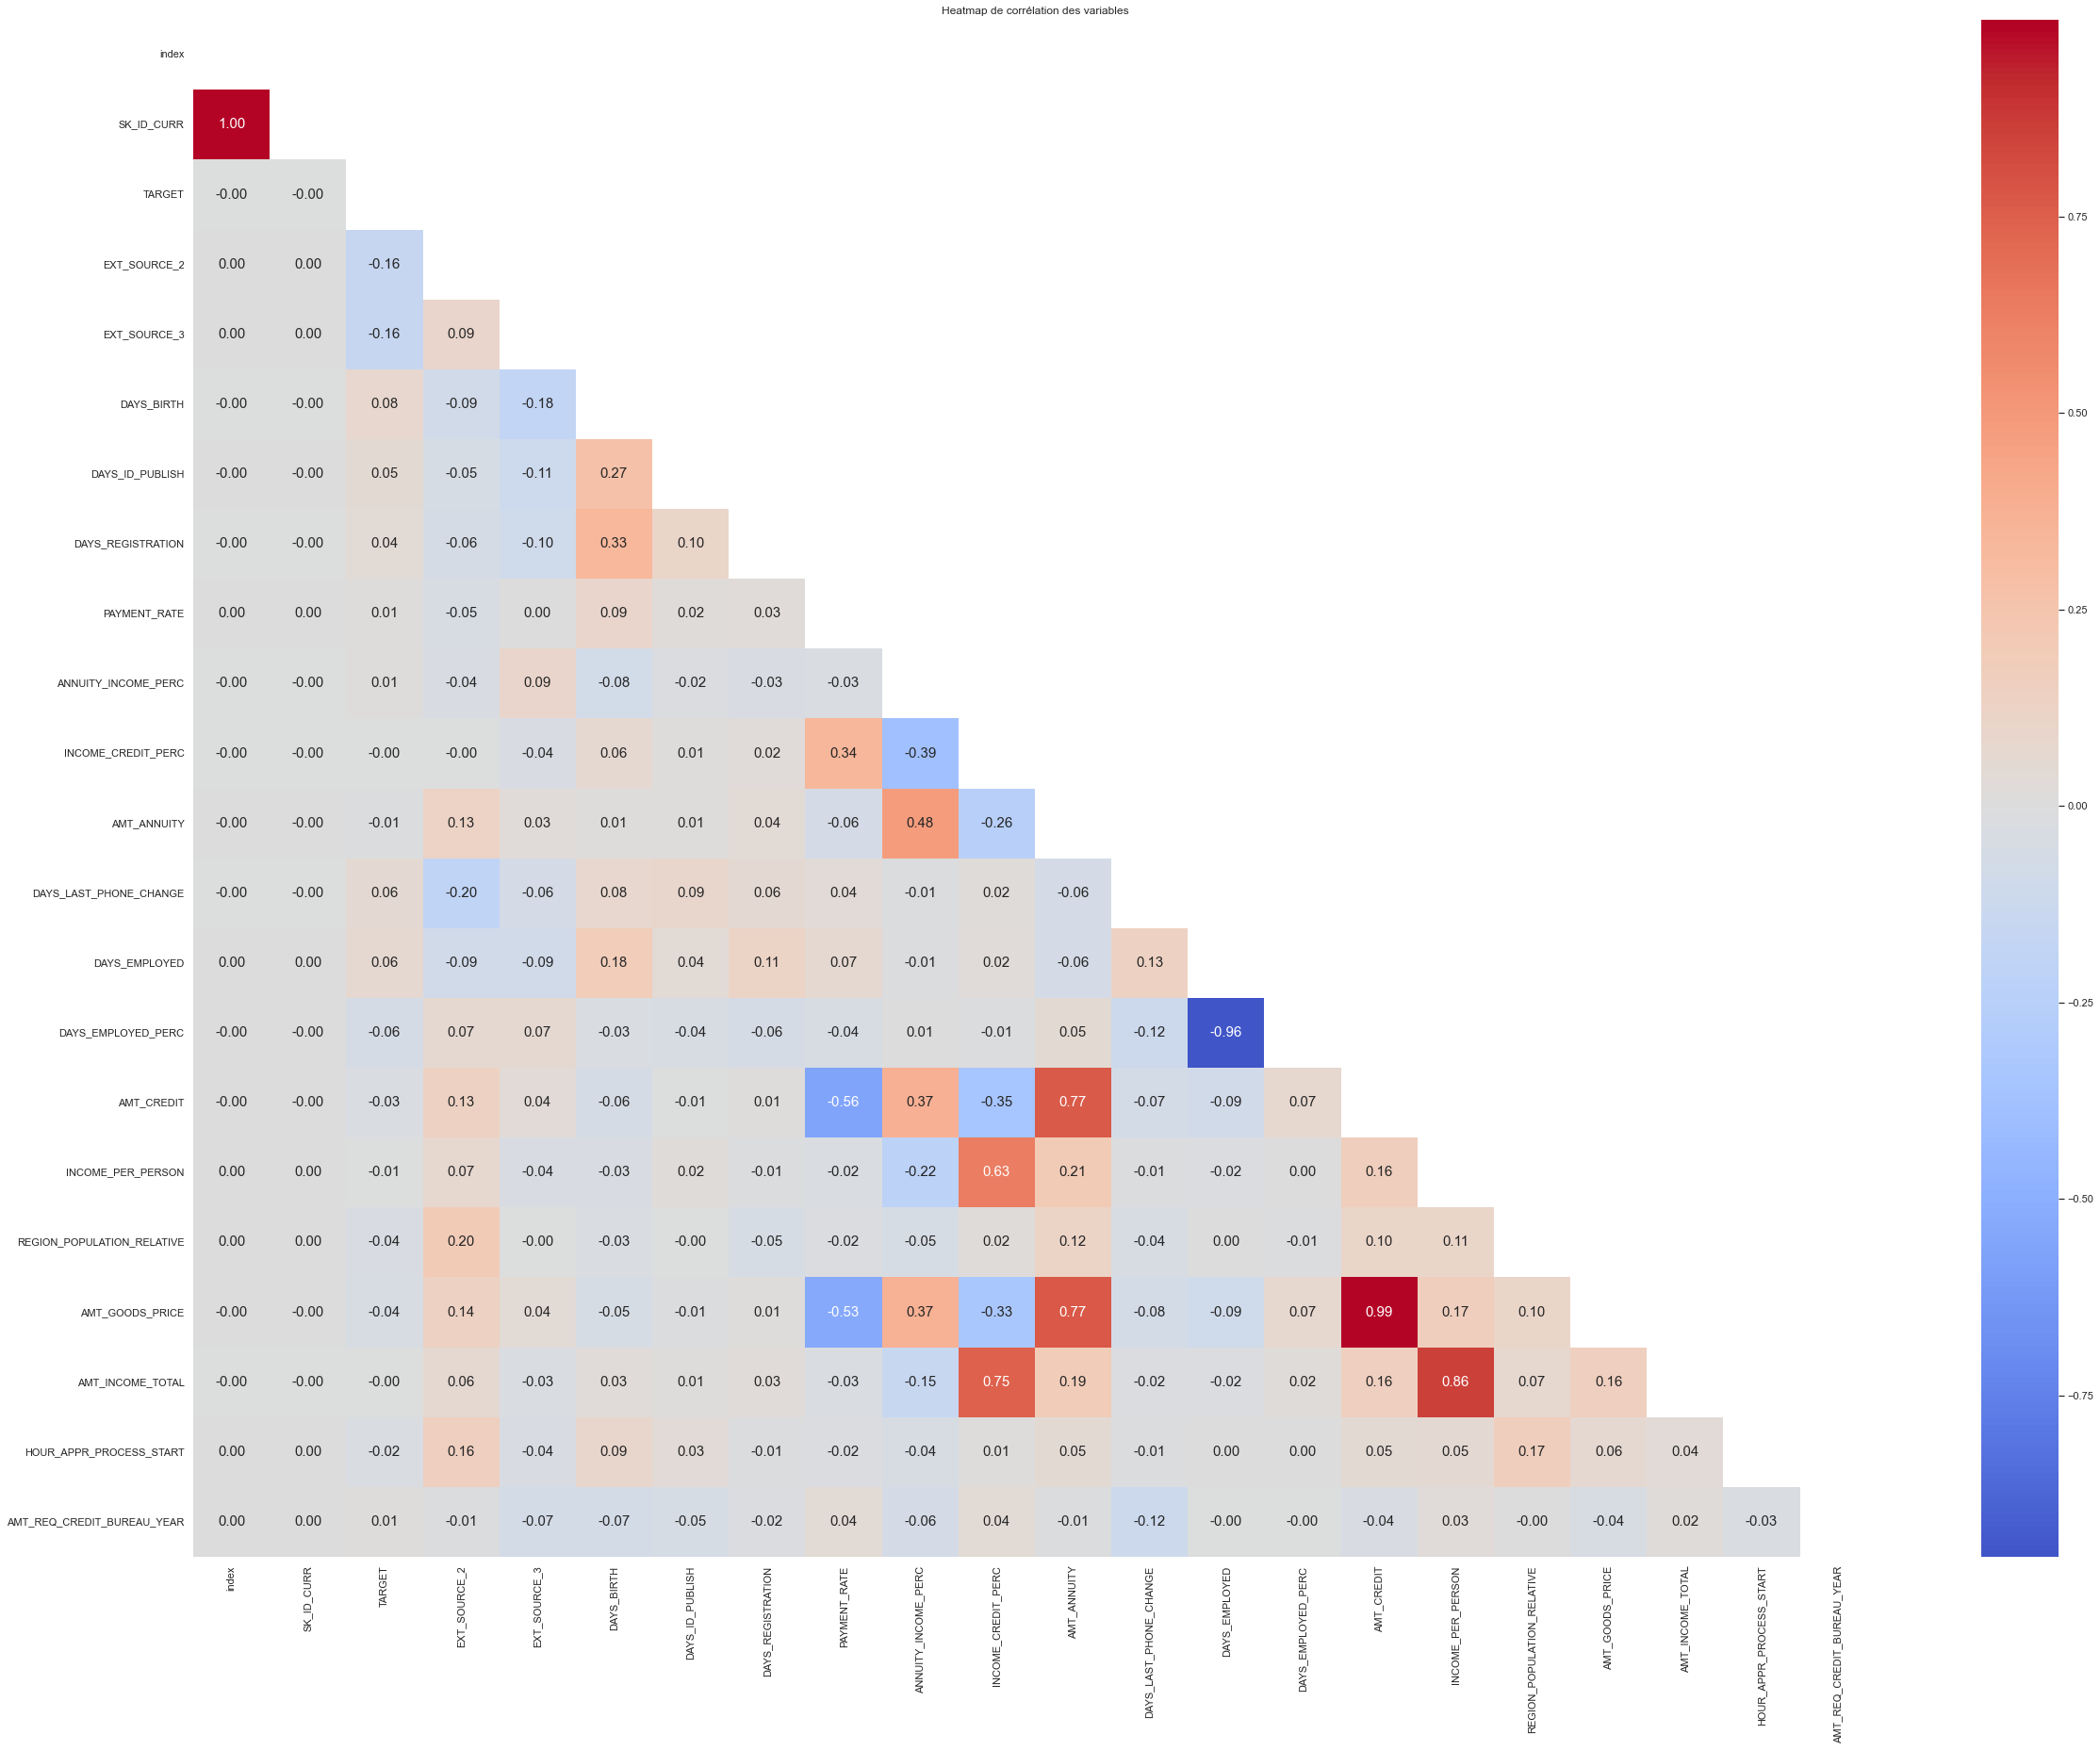

In [81]:
corr = train_2.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sb.axes_style("white"):
    f, ax = plt.subplots(figsize=(40, 30))
    ax = sb.heatmap(corr, annot=True, fmt=".2f", annot_kws={'size':15}, 
                 mask=mask, center=0, cmap="coolwarm")
plt.title("Heatmap de corrélation des variables")
# ax = sb.heatmap(corr, mask=mask, vmax=.3, square=True)
#sb.pairplot(data=data_2015_2016_02,kind='scatter')

## Préparation la base de données pour la prédiction des données

In [82]:
y=train_2['TARGET']
X=train_2.drop(columns=['TARGET','index','SK_ID_CURR'])

In [83]:
minmax_scale = MinMaxScaler()

In [84]:
X_minmax = minmax_scale.fit_transform(X)

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X_minmax, y, test_size=0.30, random_state=42)

In [86]:
print("Entrainement: {} lignes,\nTest: {} lignes.\n".format(X_train.shape[0],X_test.shape[0]))

Entrainement: 215254 lignes,
Test: 92253 lignes.



In [87]:
# add report classification (le remplcaer par matrix de confusion)

In [88]:
def print_score(classifier, X_train, y_train, X_test, y_test, train=True):
    '''
    print the accuracy score, classification report and confusion matrix of classifier
    '''
    if train:
        '''
        training performance
        '''
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, classifier.predict(X_train)))) ##taux de bon classement
        #print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, classifier.predict(X_train)))) ## matrice de confusion
        print("roc auc: {0:.4f}\n".format(roc_auc_score(y_train, classifier.predict(X_train))))
        df_cm = confusion_matrix(y_train, classifier.predict(X_train))
        #print(df_cm)
        sb.heatmap(df_cm, annot=True, cmap="Blues")
        plt.show()
        print("classification report: \n {}\n".format(classification_report(y_train, classifier.predict(X_train))))
        scoring = ['roc_auc','precision', 'recall', 'f1','accuracy']
        res = cross_validate(classifier, X_train, y_train, cv=5, scoring=scoring) ### estimation du taux de bon classement par validation croisée
        #print(res)
        print(res)
        print('test_accuracy_cross_validate:', res['test_accuracy'].mean())
        print('test_roc_auc_cross_validate:', res['test_roc_auc'].mean())
        print('test_f1_cross_validate:', res['test_f1'].mean())
        print('test_precision_cross_validate:', res['test_precision'].mean())
        print('test_recall_cross_validate:', res['test_recall'].mean())
        
    elif train==False:
        '''
        test performance
        '''
        print("Test Result:\n")        
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, classifier.predict(X_test))))
        #print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, classifier.predict(X_test))))
        df_cm = confusion_matrix(y_test, classifier.predict(X_test))
        #print(df_cm)
        sb.heatmap(df_cm, annot=True, cmap="Blues")
        plt.show()
        print("roc auc: {0:.4f}\n".format(roc_auc_score(y_test, classifier.predict(X_test))))
        print("classification report: \n {}\n".format(classification_report(y_test, classifier.predict(X_test))))
        print("Score custom: {0:.4f}\n".format(custom_metric(y_test, classifier.predict(X_test))))

### Optimisation des hyperparametres

#### GridSearchCV

***Random Forest***

In [89]:
#np.linspace(start = 500, stop = 1500, num = 6)

In [90]:
rf = RandomForestClassifier(random_state = 42)
from pprint import pprint
## Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [91]:
# Number of trees in random forest
n_estimators = [50,85,100,200,300,400,500]
# Number of features to consider at every split
#max_features = ['auto', 'sqrt']
max_features = [4, 6, 8]

# Maximum number of levels in tree
#If None, then nodes are expanded until all leaves are pure 
#or until all leaves contain less than min_samples_split samples.
max_depth = [3, 5, 8]
# Minimum number of samples required to split a node
min_samples_split = [20, 40,60]
# Minimum number of samples required at each leaf node
min_samples_leaf = [10,20,30]
# Method of selecting samples for training each tree
bootstrap = [True]

class_weight = 'balanced'

rf_param_grid = {"max_depth": max_depth,
              "max_features": max_features,
              "min_samples_split": min_samples_split,
              "min_samples_leaf": min_samples_leaf,
              "bootstrap": bootstrap,
              "n_estimators" :n_estimators,
              "criterion": ["gini"],
              "class_weight": ['balanced']}

pprint(rf_param_grid)

{'bootstrap': [True],
 'class_weight': ['balanced'],
 'criterion': ['gini'],
 'max_depth': [3, 5, 8],
 'max_features': [4, 6, 8],
 'min_samples_leaf': [10, 20, 30],
 'min_samples_split': [20, 40, 60],
 'n_estimators': [50, 85, 100, 200, 300, 400, 500]}


In [92]:
# score personalisé
# (2 * FP  + FN)/ total: on pénalise les faux positif 
# perte plus importante si un pret n'est pas remboursé que si on ne prend pas 1 client
def custom_metric(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    score=1-(((5*cm[1,0]) + cm[0, 1])/cm.sum())
    return score

custom_score= metrics.make_scorer(custom_metric, greater_is_better=True)

In [93]:
starttime = timeit.default_timer()

rf_clf = RandomForestClassifier()
rs_rf = RandomizedSearchCV(rf_clf, rf_param_grid, scoring = custom_score , cv = 5, n_jobs= -1, verbose = 1, random_state=42)
rs_rf.fit(X_train, y_train)

print("Le temps d'éxecution est :", timeit.default_timer() - starttime)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Le temps d'éxecution est : 2073.167458735


In [94]:
rs_rf.best_params_, rs_rf.best_score_

({'n_estimators': 200,
  'min_samples_split': 60,
  'min_samples_leaf': 30,
  'max_features': 6,
  'max_depth': 8,
  'criterion': 'gini',
  'class_weight': 'balanced',
  'bootstrap': True},
 0.5843608093482622)

La meilleur combinaison des hyperparamètres du décision tree est .................
({'n_estimators': 400,
  'min_samples_split': 60,
  'min_samples_leaf': 10,
  'max_features': 8,
  'max_depth': 8,
  'criterion': 'gini',
  'class_weight': 'balanced',
  'bootstrap': True},
 0.7038289634655556)

###***Gridsearch***

In [95]:
#starttime = timeit.default_timer()
#
#rf_clf = RandomForestClassifier()
#GS_rf = GridSearchCV(rf_clf, param_grid=rf_param_grid, scoring = 'accuracy', cv = 5, return_train_score=True, 
#                    n_jobs= -1, verbose = 1)
#GS_rf.fit(X_train, y_train)
#
#print("Le temps d'éxecution est :", timeit.default_timer() - starttime)

In [96]:
#GS_rf.best_params_, GS_rf.best_score_

Train Result:

accuracy score: 0.7056

roc auc: 0.6922



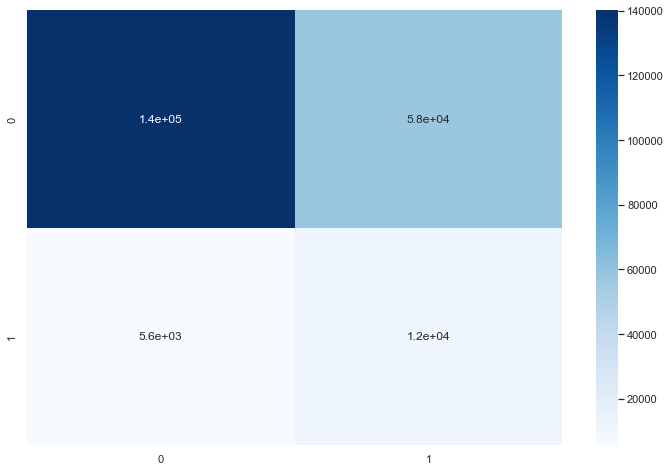

classification report: 
               precision    recall  f1-score   support

         0.0       0.96      0.71      0.82    197871
         1.0       0.17      0.68      0.27     17383

    accuracy                           0.71    215254
   macro avg       0.57      0.69      0.54    215254
weighted avg       0.90      0.71      0.77    215254


{'fit_time': array([140.34356904, 118.838696  , 121.34852123, 142.66178894,
       128.15311885]), 'score_time': array([2.50847793, 1.75037098, 1.90644789, 2.70733714, 1.78764009]), 'test_roc_auc': array([0.73601557, 0.7245994 , 0.72963847, 0.73718012, 0.73296524]), 'test_precision': array([0.16017442, 0.15773487, 0.15769148, 0.16507267, 0.16239441]), 'test_recall': array([0.63406214, 0.62726488, 0.63416739, 0.63042853, 0.641542  ]), 'test_f1': array([0.25574379, 0.25208044, 0.25257732, 0.26163762, 0.25918178]), 'test_accuracy': array([0.70202783, 0.69937981, 0.69687115, 0.71261992, 0.70387921])}
test_accuracy_cross_validate: 0.70295558235

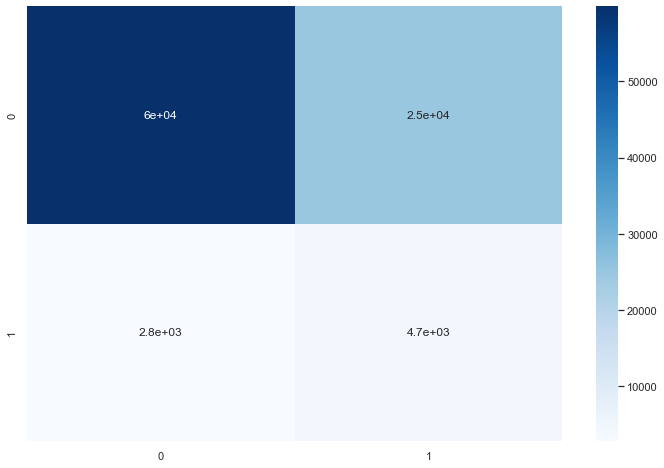

roc auc: 0.6657

classification report: 
               precision    recall  f1-score   support

         0.0       0.96      0.71      0.81     84811
         1.0       0.16      0.63      0.25      7442

    accuracy                           0.70     92253
   macro avg       0.56      0.67      0.53     92253
weighted avg       0.89      0.70      0.77     92253


Score custom: 0.5784



0.5783551754414491

In [97]:
### Afficher les performances sur Train
print_score(rs_rf.best_estimator_, X_train, y_train, X_test, y_test, train=True)
### Afficher les performances sur Test
print_score(rs_rf.best_estimator_, X_train, y_train, X_test, y_test, train=False)

#### Afficher la accuracy score sur Train
accuracy_score_rf_tr = accuracy_score(y_train, rs_rf.best_estimator_.predict(X_train))
#### Afficher la accuracy score sur Test
accuracy_score_rf_te =  accuracy_score(y_test, rs_rf.best_estimator_.predict(X_test))
accuracy_score_rf_tr, accuracy_score_rf_te

#### Afficher la Confusion Matrix sur Train
confusion_matrix_rf_tr = confusion_matrix(y_train, rs_rf.best_estimator_.predict(X_train))
#### Afficher la accuracy score sur Test
confusion_matrix_rf_te =  confusion_matrix(y_test, rs_rf.best_estimator_.predict(X_test))
confusion_matrix_rf_tr, confusion_matrix_rf_tr

#### Afficher la roc auc sur Train
roc_auc_rf_tr = roc_auc_score(y_train, rs_rf.best_estimator_.predict(X_train))
#### Afficher la accuracy score sur Test
roc_auc_rf_te =  roc_auc_score(y_test, rs_rf.best_estimator_.predict(X_test))
roc_auc_rf_tr, roc_auc_rf_te

#### Afficher la classification report sur Train
classification_report_rf_tr = classification_report(y_train, rs_rf.best_estimator_.predict(X_train))
#### Afficher la accuracy score sur Test
classification_report_rf_te =  classification_report(y_test, rs_rf.best_estimator_.predict(X_test))
#classification_report_rf_tr, classification_report_rf_te 

# Score custom
Score_custom_rf_te = custom_metric(y_test, rs_rf.best_estimator_.predict(X_test))
Score_custom_rf_te

***Logistic Regression***

In [98]:
loreg = LogisticRegression(random_state = 42)
from pprint import pprint
## Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(loreg.get_params())

Parameters currently in use:

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


In [99]:
C = [0.1, 0.5,1,2,3]
class_weight = ['balanced']
#dual = [False]
#fit_intercept = [True]
#intercept_scaling = [1,2,3,4,5,6,7,8,9,10]
#l1_ratio =  None
#max_iter = [int(x) for x in np.linspace(start = 500, stop = 2000, num = 10)]
multi_class = ['ovr']
#n_jobs = [-1, 0, 1]
#penalty = ['l1', 'l2']
#random_state = 42
solver = ['liblinear']
#tol = [0.0001,0.0002,0.0003,0.001]
#verbose = [0,1,2]
#warm_start = [False]

logistreg_param_grid = {'C': C,
                        'class_weight': class_weight}

pprint(logistreg_param_grid)

{'C': [0.1, 0.5, 1, 2, 3], 'class_weight': ['balanced']}


In [100]:
# score personalisé
# (2 * FP  + FN)/ total: on pénalise les faux positif 
# perte plus importante si un pret n'est pas remboursé que si on ne prend pas 1 client
def custom_metric(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    score=1-(((5*cm[1,0]) + cm[0, 1])/cm.sum())
    return score

custom_score= metrics.make_scorer(custom_metric, greater_is_better=True)

In [ ]:
starttime = timeit.default_timer()

loreg = LogisticRegression()
rs_loreg = RandomizedSearchCV(rf_clf, rf_param_grid, scoring = custom_score, cv = 5, n_jobs= -1, verbose = 1, random_state=42)
rs_loreg.fit(X_train, y_train)

print("Le temps d'éxecution est :", timeit.default_timer() - starttime)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [ ]:
rs_loreg.best_params_, rs_loreg.best_score_

###***Gridsearch***

In [ ]:
#loreg = LogisticRegression()
#GS_loreg = GridSearchCV(loreg, param_grid=logistreg_param_grid, scoring = 'accuracy', cv = 5, return_train_score=True, 
#                    n_jobs= -1, verbose = 1)
#GS_loreg.fit(X_train, y_train)

In [ ]:
#GS_loreg.best_params_, GS_loreg.best_score_

In [ ]:
### Afficher les performances sur Train
print_score(rs_loreg.best_estimator_, X_train, y_train, X_test, y_test, train=True)
### Afficher les performances sur Test
print_score(rs_loreg.best_estimator_, X_train, y_train, X_test, y_test, train=False)


#### Afficher la accuracy score sur Train
accuracy_score_loreg_tr = accuracy_score(y_train, rs_loreg.best_estimator_.predict(X_train))
#### Afficher la accuracy score sur Test
accuracy_score_loreg_te =  accuracy_score(y_test, rs_loreg.best_estimator_.predict(X_test))
accuracy_score_loreg_tr, accuracy_score_loreg_te

#### Afficher la Confusion Matrix sur Train
confusion_matrix_loreg_tr = confusion_matrix(y_train, rs_loreg.best_estimator_.predict(X_train))
#### Afficher la accuracy score sur Test
confusion_matrix_loreg_te =  confusion_matrix(y_test, rs_loreg.best_estimator_.predict(X_test))
confusion_matrix_loreg_tr, confusion_matrix_loreg_te

#### Afficher la roc auc sur Train
roc_auc_loreg_tr = roc_auc_score(y_train, rs_loreg.best_estimator_.predict(X_train))
#### Afficher la accuracy score sur Test
roc_auc_loreg_te =  roc_auc_score(y_test, rs_loreg.best_estimator_.predict(X_test))
roc_auc_loreg_tr, roc_auc_loreg_te

#### Afficher la classification report sur Train
classification_report_loreg_tr = classification_report(y_train, rs_loreg.best_estimator_.predict(X_train))
#### Afficher la accuracy score sur Test
classification_report_loreg_te =  classification_report(y_test, rs_loreg.best_estimator_.predict(X_test))
#classification_report_loreg_tr, classification_report_loreg_te

# Score custom
Score_custom_loreg_te = custom_metric(y_test, rs_loreg.best_estimator_.predict(X_test))
Score_custom_loreg_te

***LGBM Classifier***

In [ ]:
lightgbm = LGBMClassifier()
from pprint import pprint
## Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(lightgbm.get_params())

In [ ]:
boosting_type = ['gbdt','rf']
class_weight = ['balanced']
#importance_type  = ['split','gain']
learning_rate = [0.06, 0.075, 0.095,  0.1, 0.15]
max_depth = -1
min_split_gain= 0.0
n_estimators = [65, 70, 75, 80, 100,500,1000]
n_jobs = [-1, 0, 1]
num_leaves = 2^(max_depth)
objective = ['binary']
random_state = 42
#subsample_for_bin =[ 100000, 200000,300000]
#subsample_freq = [-1, 0, 1]

lightlgbm_param_grid = {'boosting_type': boosting_type,
                        'class_weight': class_weight,
                        'learning_rate': learning_rate,
                        'max_depth': max_depth,
                        'min_split_gain': min_split_gain,
                        'n_estimators': n_estimators,
                        'n_jobs': n_jobs,
                        'num_leaves': num_leaves,
                        'objective': objective,
                        'random_state': random_state}
pprint(lightlgbm_param_grid)

In [ ]:
# score personalisé
# (2 * FP  + FN)/ total: on pénalise les faux positif 
# perte plus importante si un pret n'est pas remboursé que si on ne prend pas 1 client
def custom_metric(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    score=1-(((5*cm[1,0]) + cm[0, 1])/cm.sum())
    return score

custom_score= metrics.make_scorer(custom_metric, greater_is_better=True)

In [ ]:
starttime = timeit.default_timer()

lightgbm = LGBMClassifier()
rs_lightgbm = RandomizedSearchCV(rf_clf, rf_param_grid, scoring = custom_score, cv = 5, n_jobs= -1, verbose = 1, random_state=42)
rs_lightgbm.fit(X_train, y_train)

print("Le temps d'éxecution est :", timeit.default_timer() - starttime)

In [ ]:
rs_lightgbm.best_params_, rs_lightgbm.best_score_

###***Gridsearch***

In [ ]:
#lightgbm = LGBMClassifier()
#GS_lightgbm = GridSearchCV(lightgbm, param_grid=lightlgbm_param_grid, scoring = 'accuracy', cv = 5, return_train_score=True, 
#                    n_jobs= -1, verbose = 1)
#GS_lightgbm.fit(X_train, y_train)

In [ ]:
#GS_lightgbm.best_params_, GS_lightgbm.best_score_

In [ ]:
### Afficher les performances sur Train
print_score(rs_lightgbm.best_estimator_, X_train, y_train, X_test, y_test, train=True)
### Afficher les performances sur Test
print_score(rs_lightgbm.best_estimator_, X_train, y_train, X_test, y_test, train=False)


#### Afficher la accuracy score sur Train
accuracy_score_lightgbm_tr = accuracy_score(y_train, rs_lightgbm.best_estimator_.predict(X_train))
#### Afficher la accuracy score sur Test
accuracy_score_lightgbm_te =  accuracy_score(y_test, rs_lightgbm.best_estimator_.predict(X_test))
accuracy_score_lightgbm_tr, accuracy_score_lightgbm_te

#### Afficher la Confusion Matrix sur Train
confusion_matrix_lightgbm_tr = confusion_matrix(y_train, rs_lightgbm.best_estimator_.predict(X_train))
#### Afficher la accuracy score sur Test
confusion_matrix_lightgbm_te =  confusion_matrix(y_test, rs_lightgbm.best_estimator_.predict(X_test))
confusion_matrix_lightgbm_tr, confusion_matrix_lightgbm_te

#### Afficher la roc auc sur Train
roc_auc_lightgbm_tr = roc_auc_score(y_train, rs_lightgbm.best_estimator_.predict(X_train))
#### Afficher la accuracy score sur Test
roc_auc_lightgbm_te =  roc_auc_score(y_test, rs_lightgbm.best_estimator_.predict(X_test))
roc_auc_lightgbm_tr, roc_auc_lightgbm_te

#### Afficher la classification report sur Train
classification_report_lightgbm_tr = classification_report(y_train, rs_lightgbm.best_estimator_.predict(X_train))
#### Afficher la accuracy score sur Test
classification_report_lightgbm_te =  classification_report(y_test, rs_lightgbm.best_estimator_.predict(X_test))
classification_report_lightgbm_tr, classification_report_lightgbm_te 

# Score custom
Score_custom_lightgbm_te = custom_metric(y_test, rs_lightgbm.best_estimator_.predict(X_test))
Score_custom_lightgbm_te

***AUC-ROC Curve***

In [ ]:
# predict probabilities
pred_prob1 = rs_rf.best_estimator_.predict_proba(X_test)
pred_prob2 = rs_loreg.best_estimator_.predict_proba(X_test)
pred_prob3 = rs_lightgbm.best_estimator_.predict_proba(X_test)

In [ ]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, pred_prob3[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

In [ ]:
from sklearn.metrics import roc_auc_score

# auc scores
auc_score1 = roc_auc_score(y_test, pred_prob1[:,1])
auc_score2 = roc_auc_score(y_test, pred_prob2[:,1])
auc_score3 = roc_auc_score(y_test, pred_prob3[:,1])

print(auc_score1, auc_score2, auc_score3)

In [ ]:
# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Random classifier')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='logistique regression')
plt.plot(fpr3, tpr3, linestyle='--',color='yellow', label='light GBM')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

## classification report des modèles : Train

In [ ]:
print('classification report train')
print("=="*50)
print(classification_report_rf_tr)
print("=="*50)
print(classification_report_loreg_tr)
print("=="*50)
print(classification_report_lightgbm_tr)
print("=="*50)

## classification report des modèles : Test

In [ ]:
print('classification report test')
print("=="*50)
print(classification_report_rf_te)
print("=="*50)
print(classification_report_loreg_te)
print("=="*50)
print(classification_report_lightgbm_te)
print("=="*50)

### Heatmap des performances des différents modèles

###***train***

In [ ]:
## tableau des performances sur l'échantillon d'apprentissage
tab_app = pd.DataFrame(data = [[accuracy_score_rf_tr, roc_auc_rf_tr],[accuracy_score_loreg_tr, roc_auc_loreg_tr],[accuracy_score_lightgbm_tr, roc_auc_lightgbm_tr]],
                  columns=['AUC','ROC_AUC'], index = ['Random Forest','Logistique Reg', 'LightGBM'])
## graphique 
plt.figure(figsize=(15,10))
g = sb.heatmap(tab_app,linewidths=.2, cmap="YlGnBu", annot=True, fmt=".3f")
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 12)
g.set_xticklabels(g.get_xticklabels(), rotation = 45, fontsize = 12)
plt.title("Performances sur l'échantillon Train")
plt.show()

###***test***

In [ ]:
## tableau des performances sur l'échantillon d'apprentissage
tab_app = pd.DataFrame(data = [[accuracy_score_rf_te, roc_auc_rf_te],[accuracy_score_loreg_te, roc_auc_loreg_te],[accuracy_score_lightgbm_te, roc_auc_lightgbm_te]],
                  columns=['AUC','ROC_AUC'], index = ['Random Forest','Logistique Reg', 'LightGBM'])
## graphique 
plt.figure(figsize=(15,10))
g = sb.heatmap(tab_app,linewidths=.2, cmap="YlGnBu", annot=True, fmt=".3f")
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 12)
g.set_xticklabels(g.get_xticklabels(), rotation = 45, fontsize = 12)
plt.title("Performances sur l'échantillon Test")
plt.show()

### Comparaison Test elec Cross_validate & test : R2 et RMSE

In [ ]:
## tableau des performances sur l'échantillon d'apprentissage
tab_app = pd.DataFrame(data = [[roc_auc_rf_te, 0.17, 0.67, 0.25,accuracy_score_rf_te,0.7304111085298495,0.16035454211782363,0.6296962482041282,0.255602628263453,0.7037639195777603],[roc_auc_loreg_te,0.16,0.68,0.27,accuracy_score_loreg_te,0.7319774348159168,0.1604455361052562,0.6332053179979699,0.2565404454872203,0.7027465262481678],[roc_auc_lightgbm_te,0.16,0.63,0.25,accuracy_score_lightgbm_te,0.7320054383247556,0.16073249216559737,0.6352760520970785,0.2565404454872203,0.7025699880953123]],
                  columns=['roc_auc','precision','recall', 'f1','accuracy','test_roc_auc_cv','precision_cv','test_recall_cv','test_f1_micro_cv','test_accuracy_cv'], index = ['Random Forest','Logistique Reg', 'LightGBM'])
## graphique 
plt.figure(figsize=(15,10))
g = sb.heatmap(tab_app,linewidths=.2, cmap="YlGnBu", annot=True, fmt=".3f")
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 12)
g.set_xticklabels(g.get_xticklabels(), rotation = 45, fontsize = 12)
plt.title("Comparaison stabilité métriques par validation croisée")
plt.show()

### MIEUX COMPRENDRE L’INTERPRÉTATION DE MODÈLES

In [ ]:
import shap

In [ ]:
X=train_2.drop(columns=['index','SK_ID_CURR'])

In [ ]:
# Create Tree Explainer object that can calculate shap values
explainer = shap.TreeExplainer(rs_rf.best_estimator_)

In [ ]:
X.loc[[421]]

In [ ]:
# Calculate Shap values
choosen_instance = X.loc[[421]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

In [ ]:
# Calculate Shap values
choosen_instance = X.loc[[4021]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

In [ ]:
# Calculate Shap values
choosen_instance = X.loc[[310]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

In [ ]:
 X.loc[[70036]]

In [ ]:
# Calculate Shap values
choosen_instance = X.loc[[70036]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

In [ ]:
choosen_instance = X
shap.summary_plot(shap_values, choosen_instance, plot_type="bar")

In [ ]:
# visualize the first prediction's explanation
#shap.plots.waterfall(shap_values[0])

In [ ]:
import lime

In [ ]:
import lime.lime_tabular

In [ ]:
y=train_2['TARGET']
X=train_2.drop(columns=['TARGET','index','SK_ID_CURR'])
#X=train_2.drop(columns=['index','SK_ID_CURR'])

In [ ]:
minmax_scale = MinMaxScaler()

In [ ]:
X_minmax = minmax_scale.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_minmax, y, test_size=0.30, random_state=42)

In [ ]:
print("Entrainement: {} lignes,\nTest: {} lignes.\n".format(X_train.shape[0],X_test.shape[0]))

In [ ]:
lime_ = lime.lime_tabular.LimeTabularExplainer(X_train,
                             feature_names=X.columns,
                             class_names=["O", "1"],
                             discretize_continuous=False)
                            

# Interpret restaurant 1
exp = lime_.explain_instance(pd.DataFrame(X_train).iloc[10],
                             rs_rf.best_estimator_.predict_proba,
                             num_samples=100)

exp.show_in_notebook(show_table=True)

exp.as_pyplot_figure()
plt.tight_layout()

In [ ]:
lime_ = lime.lime_tabular.LimeTabularExplainer(X_train,
                             feature_names=X.columns,
                             class_names=["O", "1"],
                             discretize_continuous=False)
                            

# Interpret restaurant 1
exp = lime_.explain_instance(pd.DataFrame(X_train).iloc[1000],
                             rs_rf.best_estimator_.predict_proba,
                             num_samples=100)

exp.show_in_notebook(show_table=True)

exp.as_pyplot_figure()
plt.tight_layout()

In [ ]:
lime_ = lime.lime_tabular.LimeTabularExplainer(X_train,
                             feature_names=X.columns,
                             class_names=["O", "1"],
                             discretize_continuous=False)
                            

# Interpret restaurant 1
exp = lime_.explain_instance(pd.DataFrame(X_train).iloc[20000],
                             rs_rf.best_estimator_.predict_proba,
                             num_samples=100)

exp.show_in_notebook(show_table=True)

exp.as_pyplot_figure()
plt.tight_layout()